In [28]:
%matplotlib notebook

In [209]:
import pandas as pd
import numpy as np
import joblib
import shap
import optuna
import lightgbm as lgb
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, auc, f1_score, roc_curve, confusion_matrix
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [3]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')


In [6]:
df.shape

(6362620, 11)

In [5]:
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [3]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [4]:
df[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest']].drop_duplicates().shape

(6362620, 9)

- Нету полных дубликатов

In [7]:
df[['nameOrig', 'nameDest', 'step']].drop_duplicates().shape

(6362620, 3)

In [11]:
df[['nameOrig', 'step']].drop_duplicates().shape

(6362573, 2)

In [12]:
df[['nameDest', 'step']].drop_duplicates().shape

(6046187, 2)

- Нету дубликатов внутри одного временного интервала.
- Есть дубликаты в комбинациях отправителя и шага.
- Есть дубликаты в комбинациях получателя и шага.


- Аггрегируются по шагу в комбинациях отправителя и получателя, либо в один шаговый интервал можно делать только 1 раз совместную транзакцию.

In [13]:
df[['nameOrig', 'nameDest']].drop_duplicates().shape

(6362620, 2)

- Все комбинации отправителя и получателя уникальны.

In [29]:
df['nameOrig'].describe()

count         6362620
unique        6353307
top       C1902386530
freq                3
Name: nameOrig, dtype: object

In [16]:
df['nameDest'].value_counts().head(50)

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
C977993101      96
C97730845       96
C392292416      95
C1899073220     92
C306206744      91
C1234776885     90
C1782113663     90
C998351292      89
C716083600      89
C909295153      88
C667346055      86
C1674899618     86
C1262822392     85
C1816757085     84
C1255024717     84
C453211571      84
C2006081398     83
C932583850      82
C1504109395     82
C991363637      82
C1303868418     81
C728526866      81
C214774813      80
C33524623       80
C1883840933     80
C1870252780     80
C766681183      80
C1721246982     80
C11003494       80
C1909597726     80
C662736689      79
C1167066016     79
C769342184      78
C423580937      77
C803116137      77
C1297685781     76
C1850180796     76
C1730752455     76
C863811613      75
C2049813033     75
Name: count, dtype: int64

- Большинство оригинаторов уникальные, максимальное кол-во транзакции 3.
- Адресаты имеют больше дубликатов, максимум 113 раз.

- Данные - уже являются дневными (или другой шаг) суммами транзакции между двумя сторонами. 
- Повторные транзакции между одинаковыми сторонами не происходят. 
- Отправители, в основном, уникальные. 
- Получатели повторяются чаще, скорее всего продавцы или поставщики услуг (мерчанты).

In [20]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Нет пропусков

# EDA

## Correlations, Distributions and Transaction Types

<IPython.core.display.Javascript object>


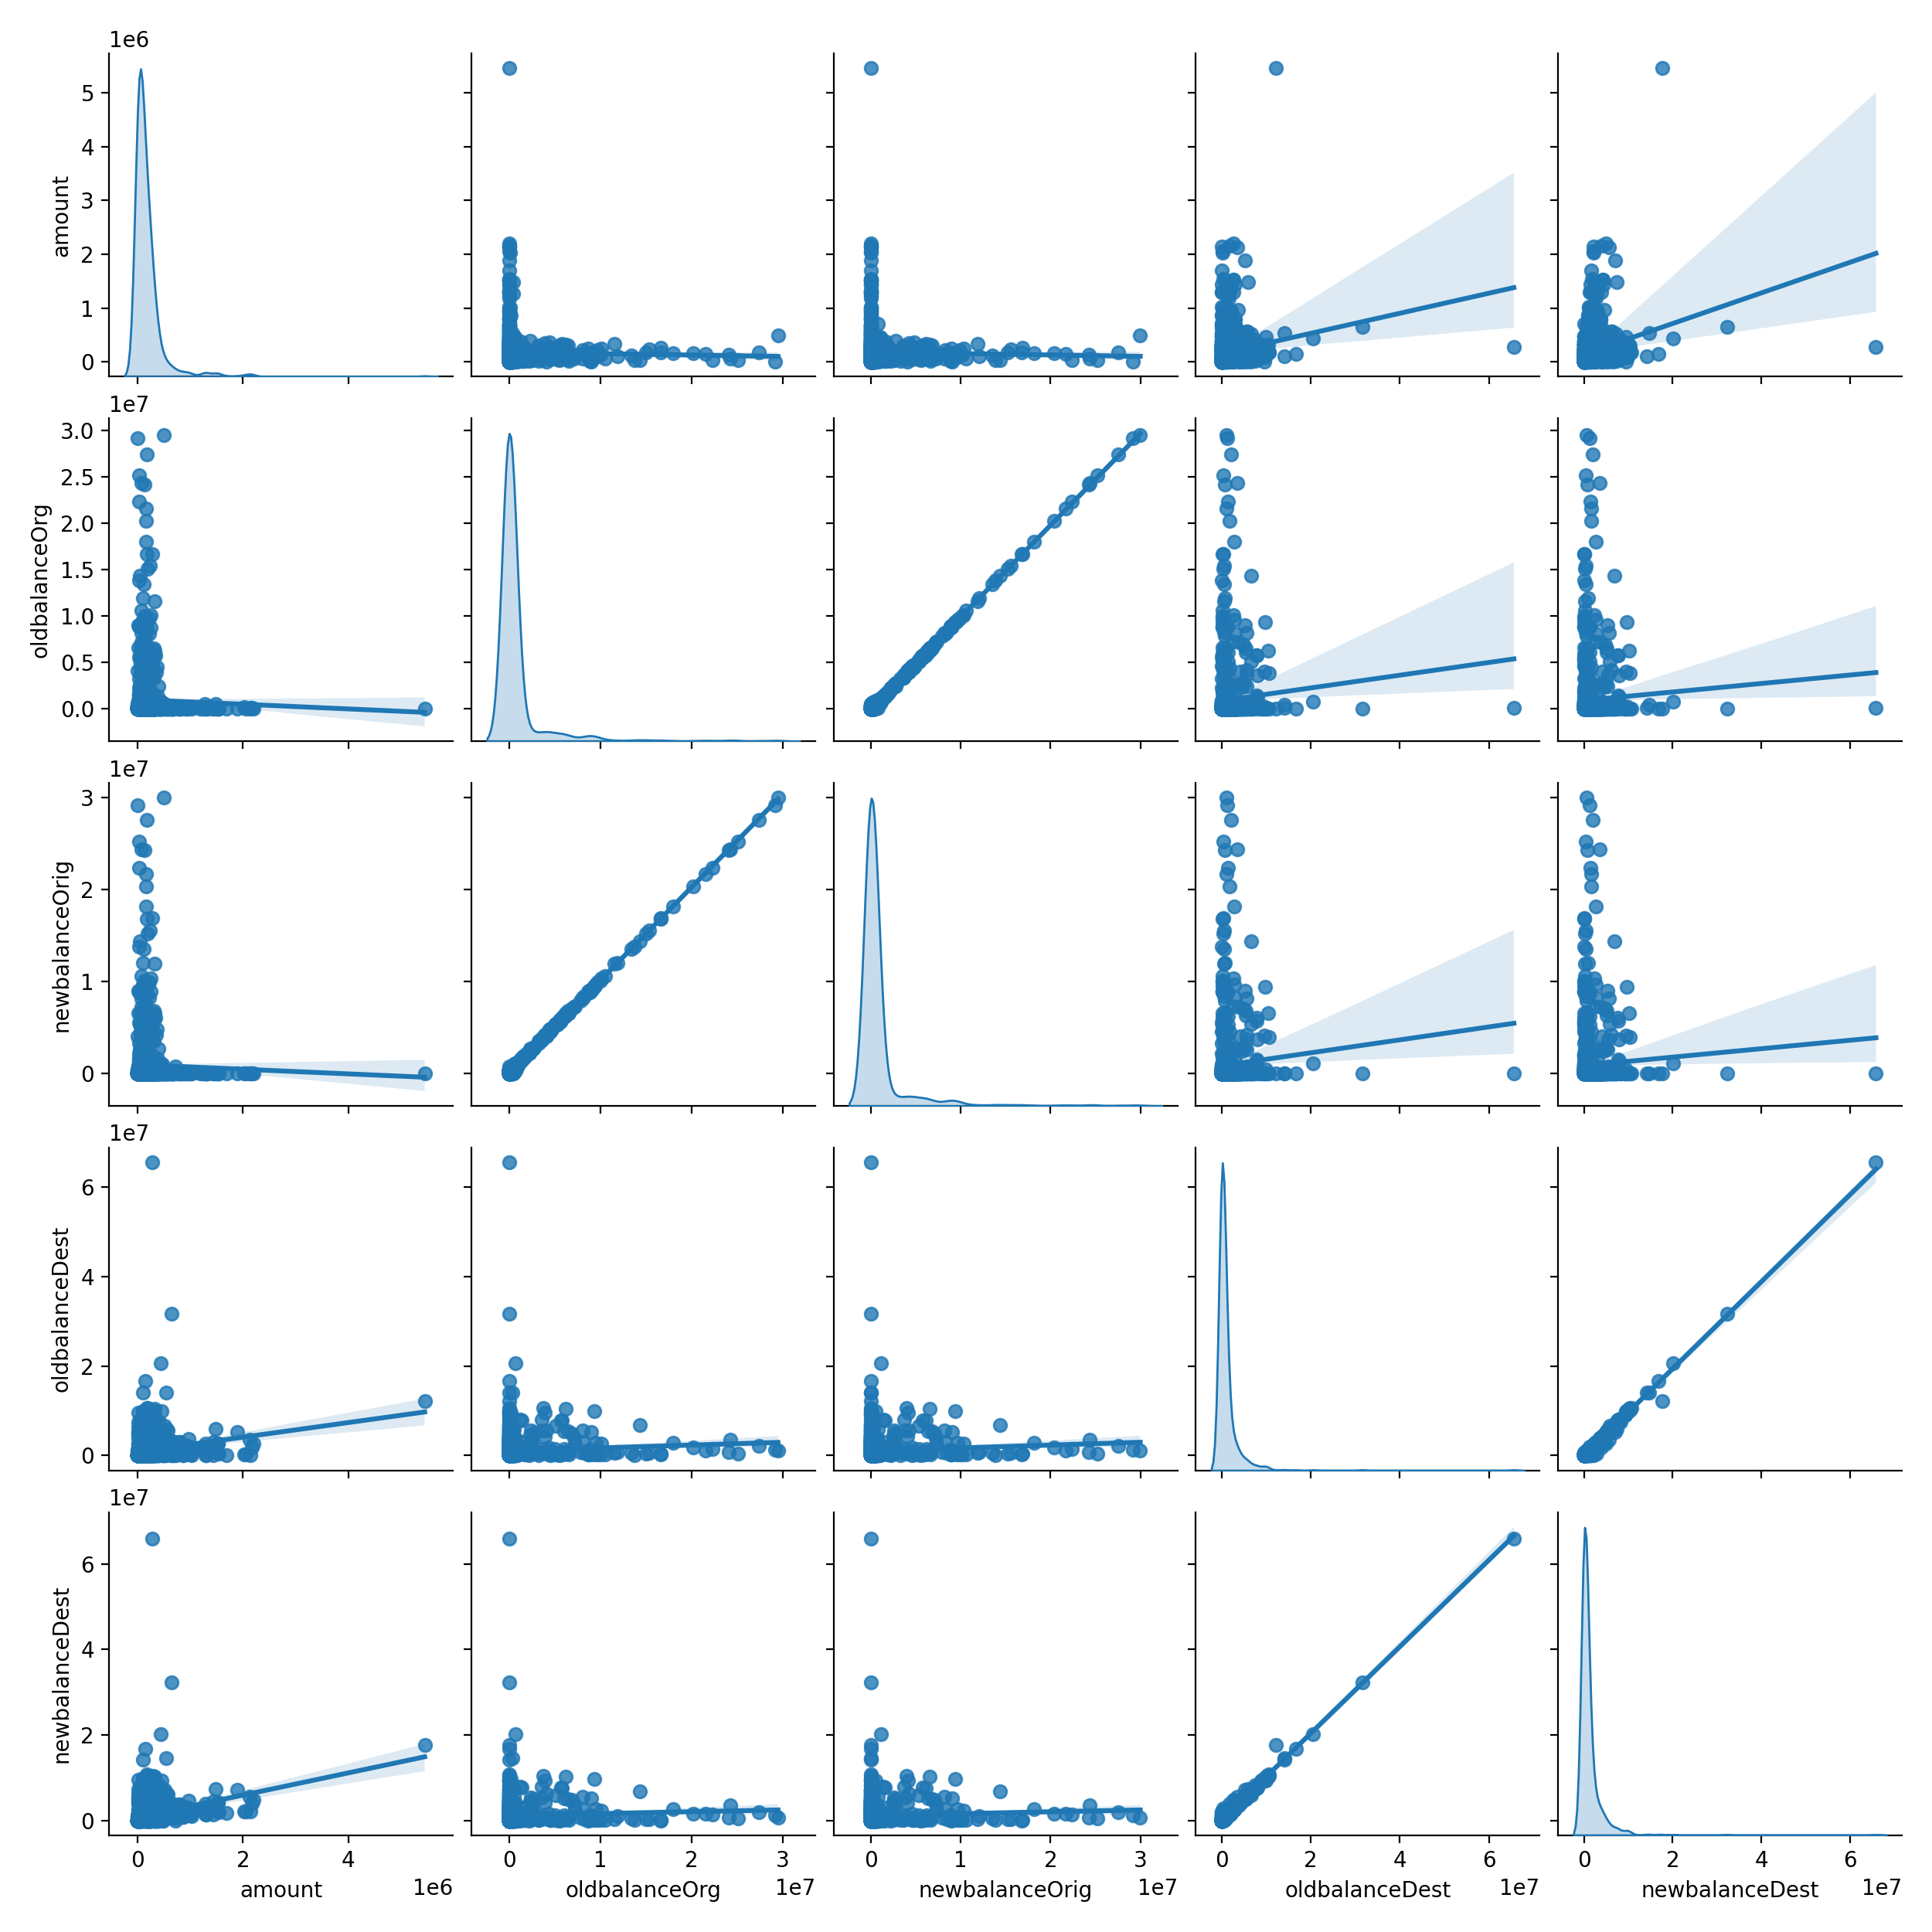

In [45]:
sns.pairplot(df[[
    'amount', 
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest']].sample(1000),
    kind='reg',
    diag_kind='kde'
);

- Никаких странных зависимостей, в целом, но есть множество транзакции с ненулевой суммой. 
- Назовем эту разницу дельтой, куда могут входить: оплата за сервисы, коммиссии при отрицательных значениях или разлинчые виды пополнении при положительном.

In [62]:
df['balanceChngOrig'] = (df['newbalanceOrig'] - df['oldbalanceOrg'])
df['balanceChngDest'] = (df['newbalanceDest'] - df['oldbalanceDest'])
df['balanceDelta'] = df['balanceChngOrig'] + df['balanceChngDest']


<IPython.core.display.Javascript object>


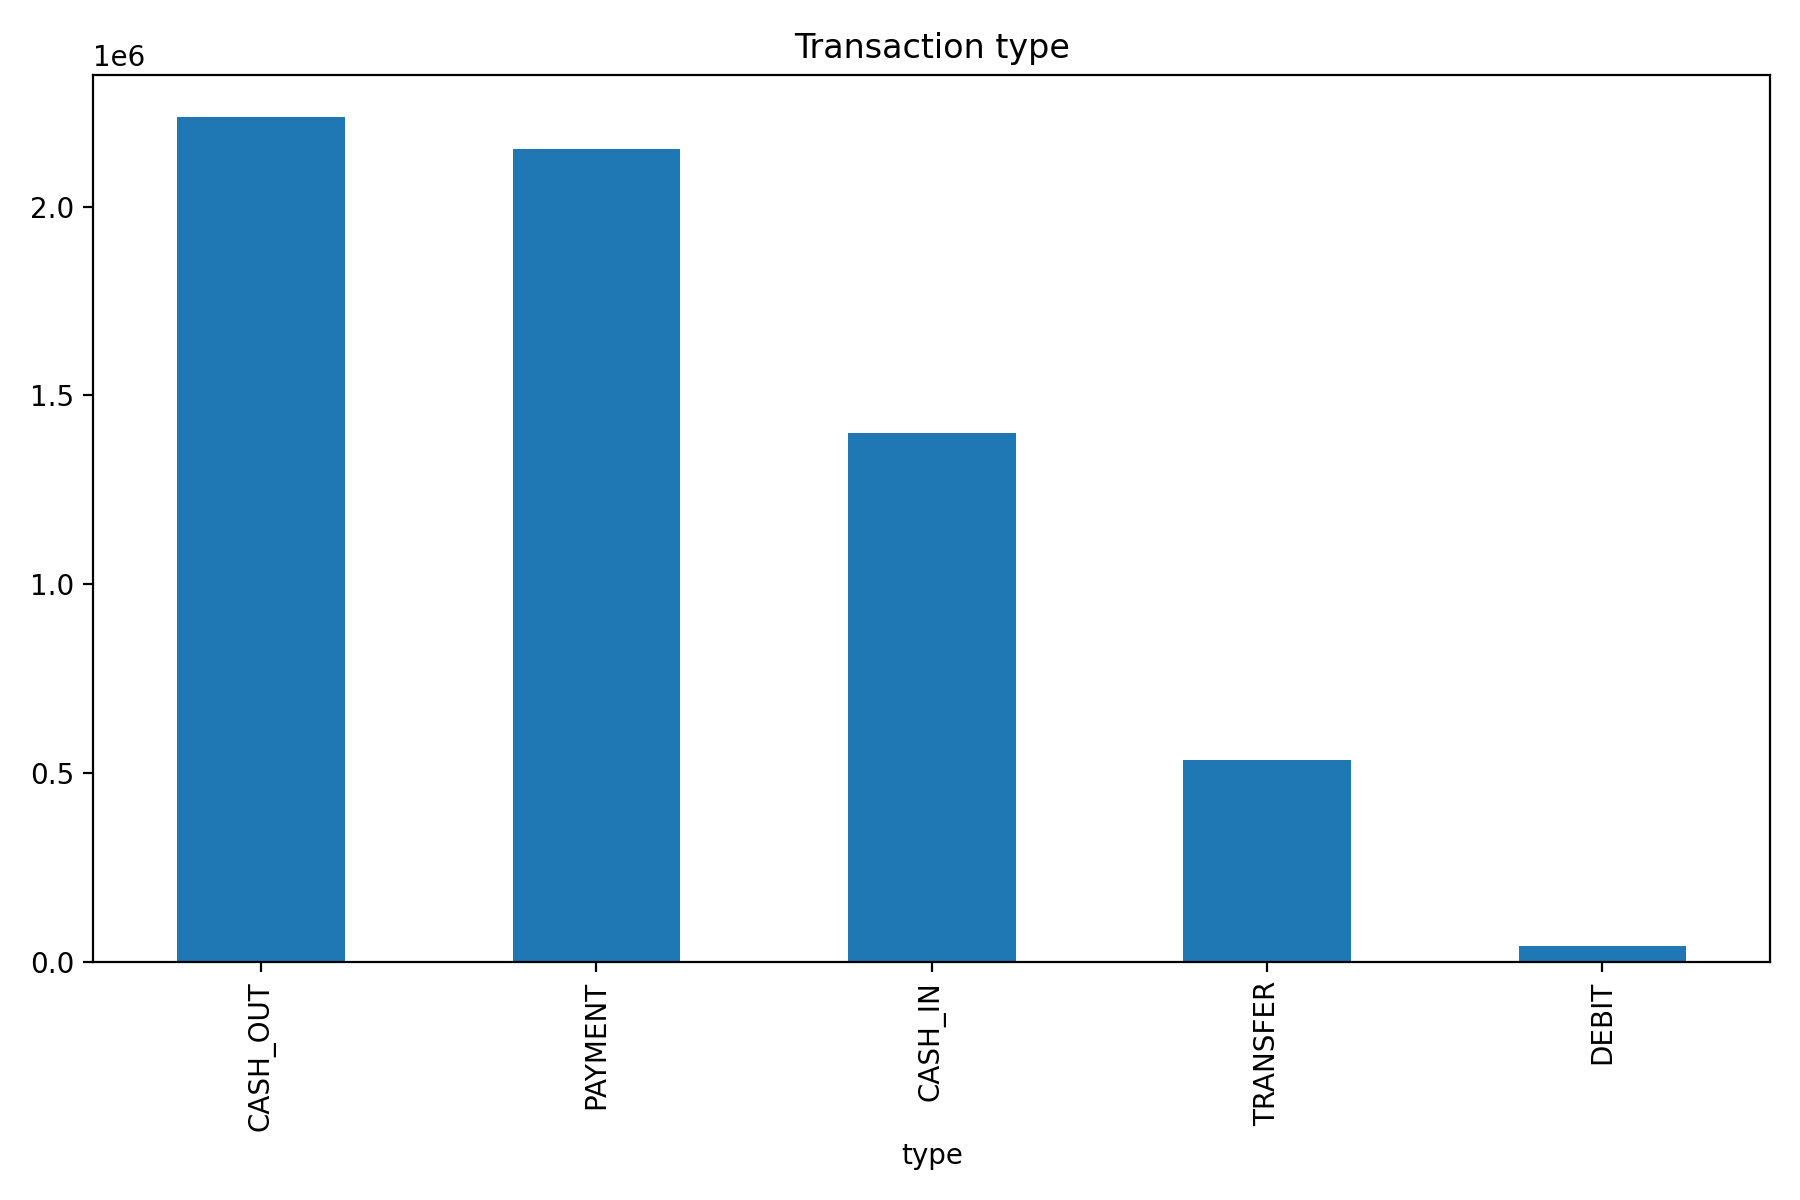

In [32]:
f, ax = plt.subplots(1, 1, figsize=(5, 1))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(9,6))
plt.tight_layout();

In [38]:
df['isFraud'].sum()

8213

<IPython.core.display.Javascript object>


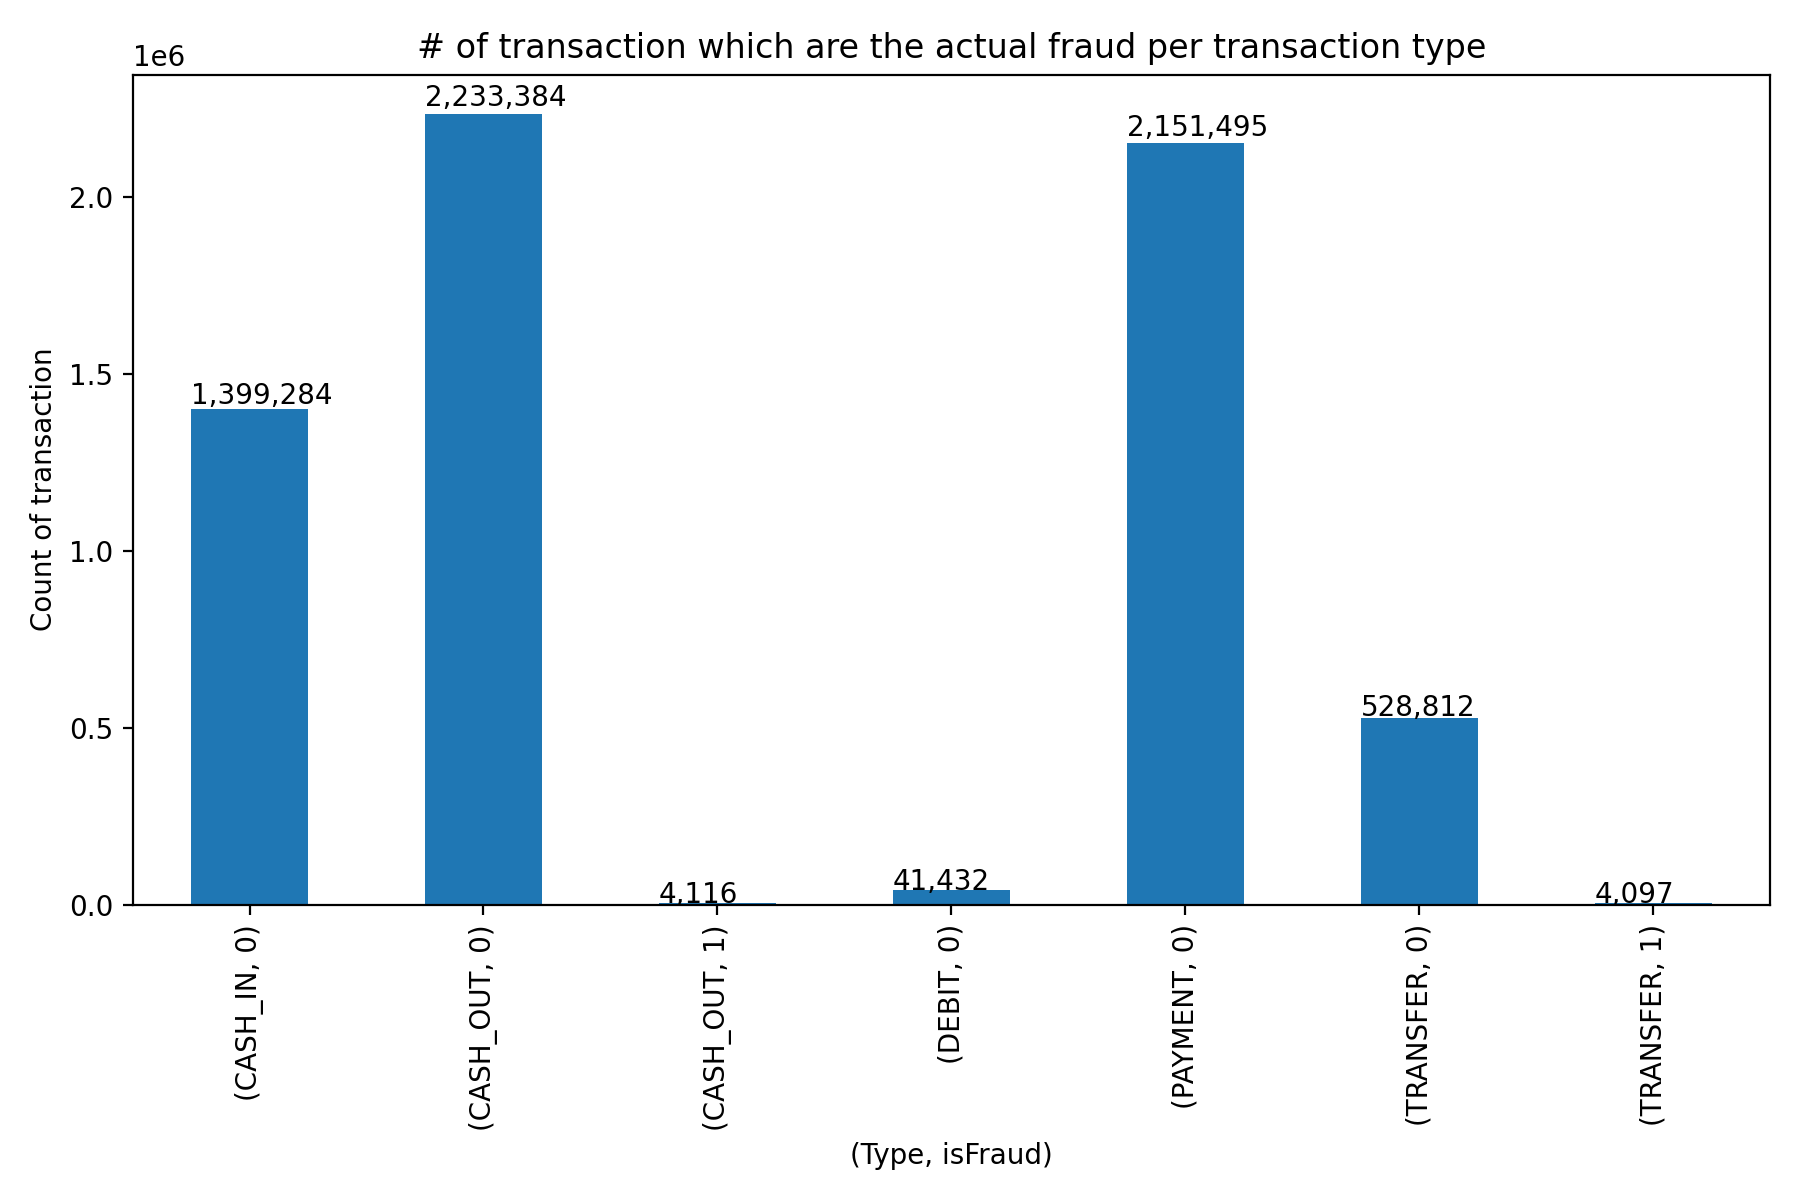

In [37]:
f, ax = plt.subplots(1, 1, figsize=(9, 6))
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.tight_layout();


- Фроды только в CASH_OUT и TRASFER поровну. 
- CASH_OUT имеет намного меньшее соотношение позитивных к негативным в сравнении с TRANSFER - 0.18% против 0.77% соответственно.

In [70]:
df_only_badtypes = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])]
df_only_badtypes['isFraud_type'] = df_only_badtypes['type'] + '_' + df_only_badtypes['isFraud'].astype(str)


/var/folders/f4/lwpnx61j46nf6mcfpw7j_sc00000gn/T/ipykernel_3589/1217329129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_badtypes['isFraud_type'] = df_only_badtypes['type'] + '_' + df_only_badtypes['isFraud'].astype(str)


## Feature distributions accross types

<IPython.core.display.Javascript object>


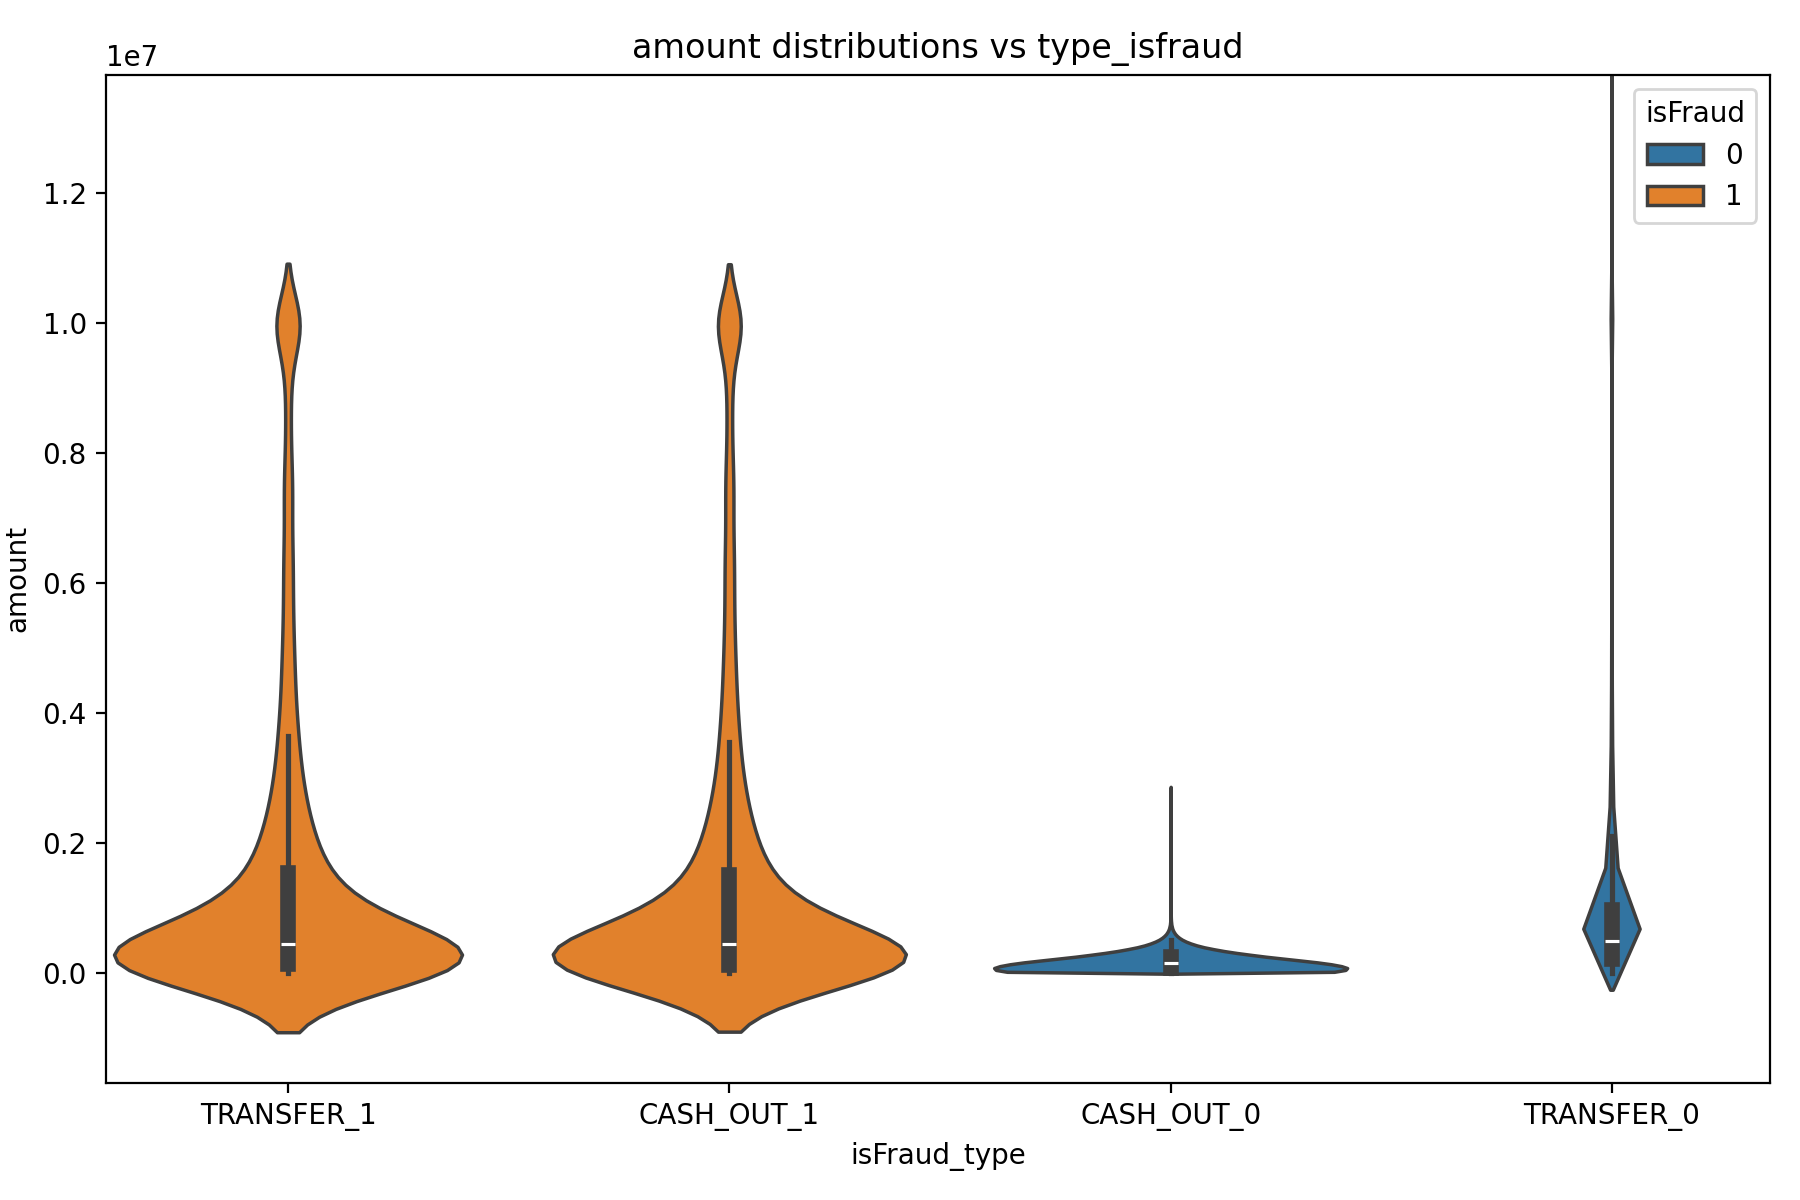

In [72]:
y = 'amount'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- Amount не бывает отрицательным в честных сделках.
- Распределения amount и в переводах и в выводах одинаковы. Скорее всего какие-то похожие схемы в плане объемов денег.
- Добропорядочные выводы средств имеют узкое распределение, сконцентрированы в районе <= 1e6
- Добропорядочные переводы имеют более широкое распределение, с большим кол-вом аутлаеров.

<IPython.core.display.Javascript object>


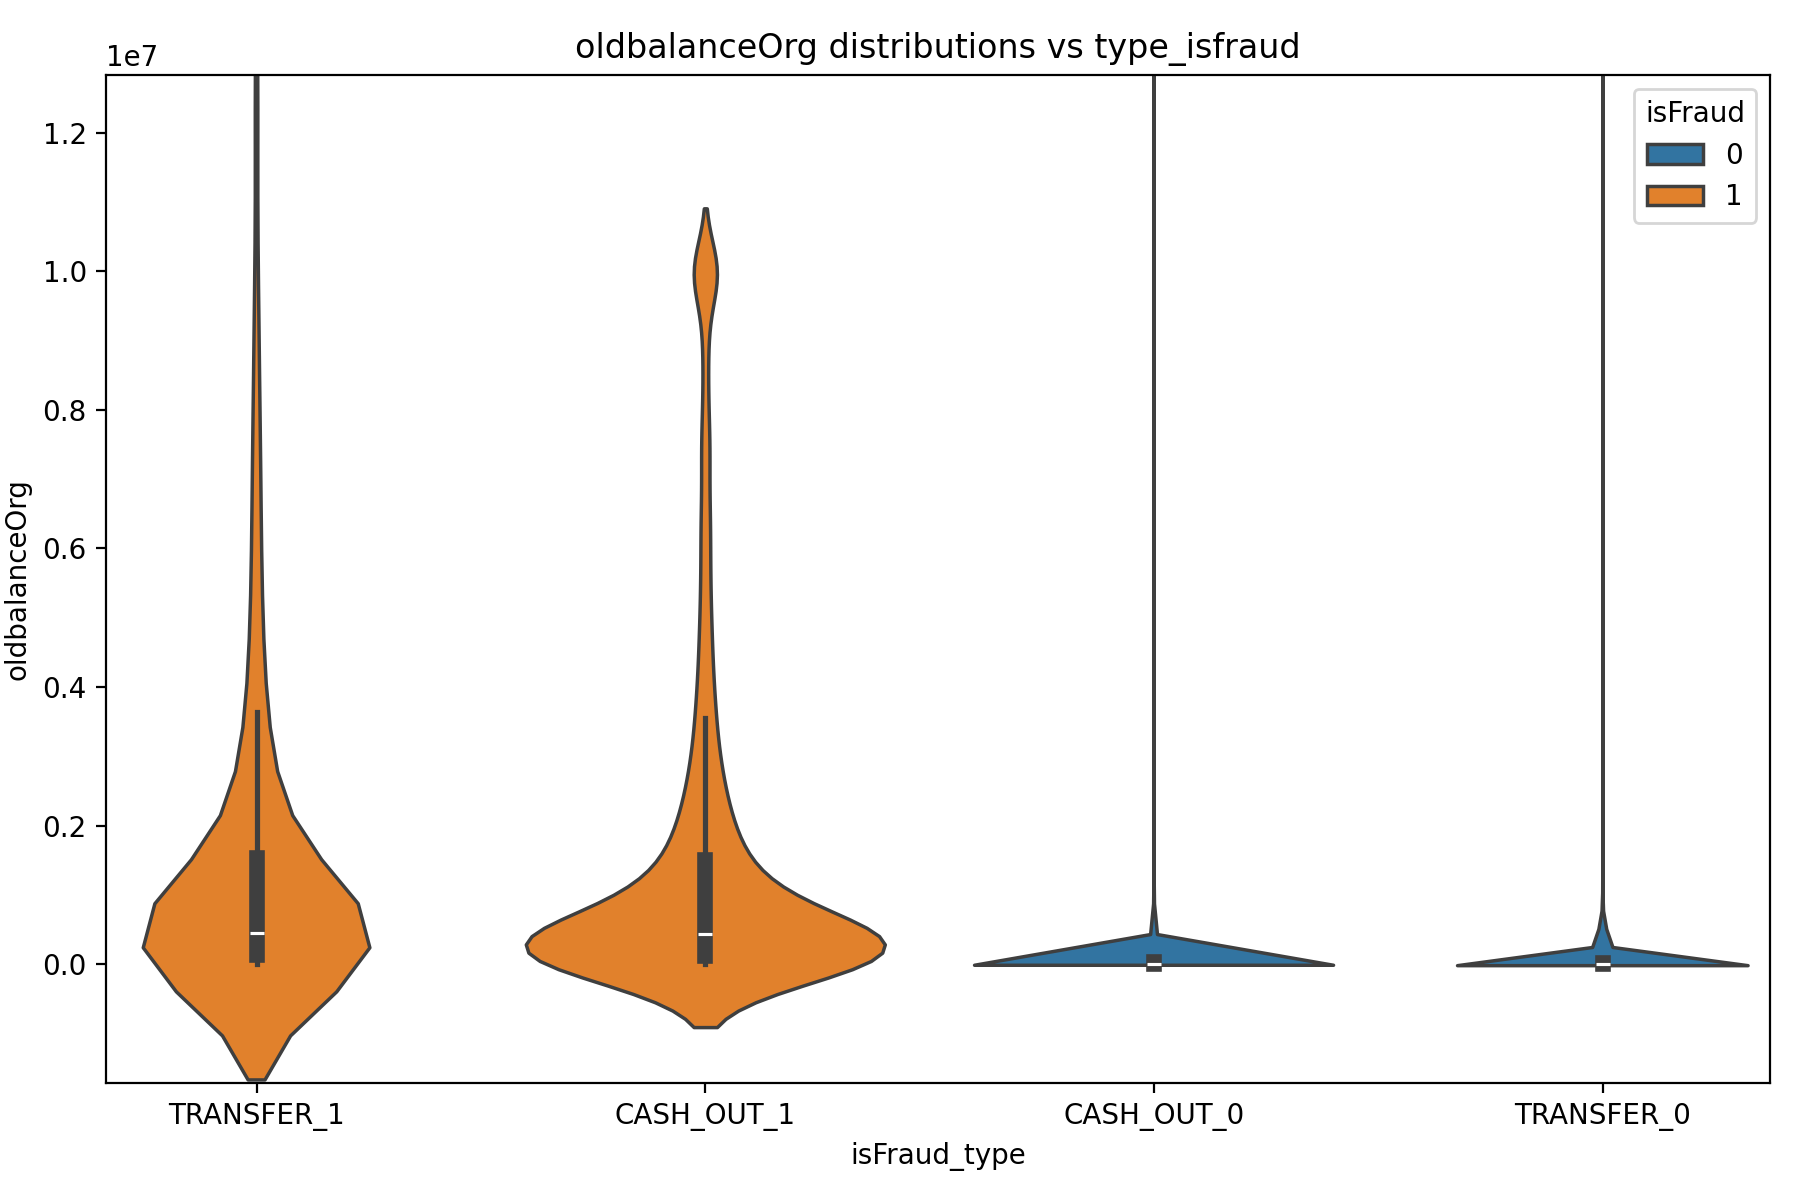

In [74]:
y = 'oldbalanceOrg'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- Отправители не имеют отрицательный баланс в честных сделках. Распределения узкие (<1e6) с большим кол-вом аутлаеров. 
- У мошенников изначальные балансы более широко распределены и намного выше, в среднем, чем у честных. Могут иметь отрицательные значения.

<IPython.core.display.Javascript object>


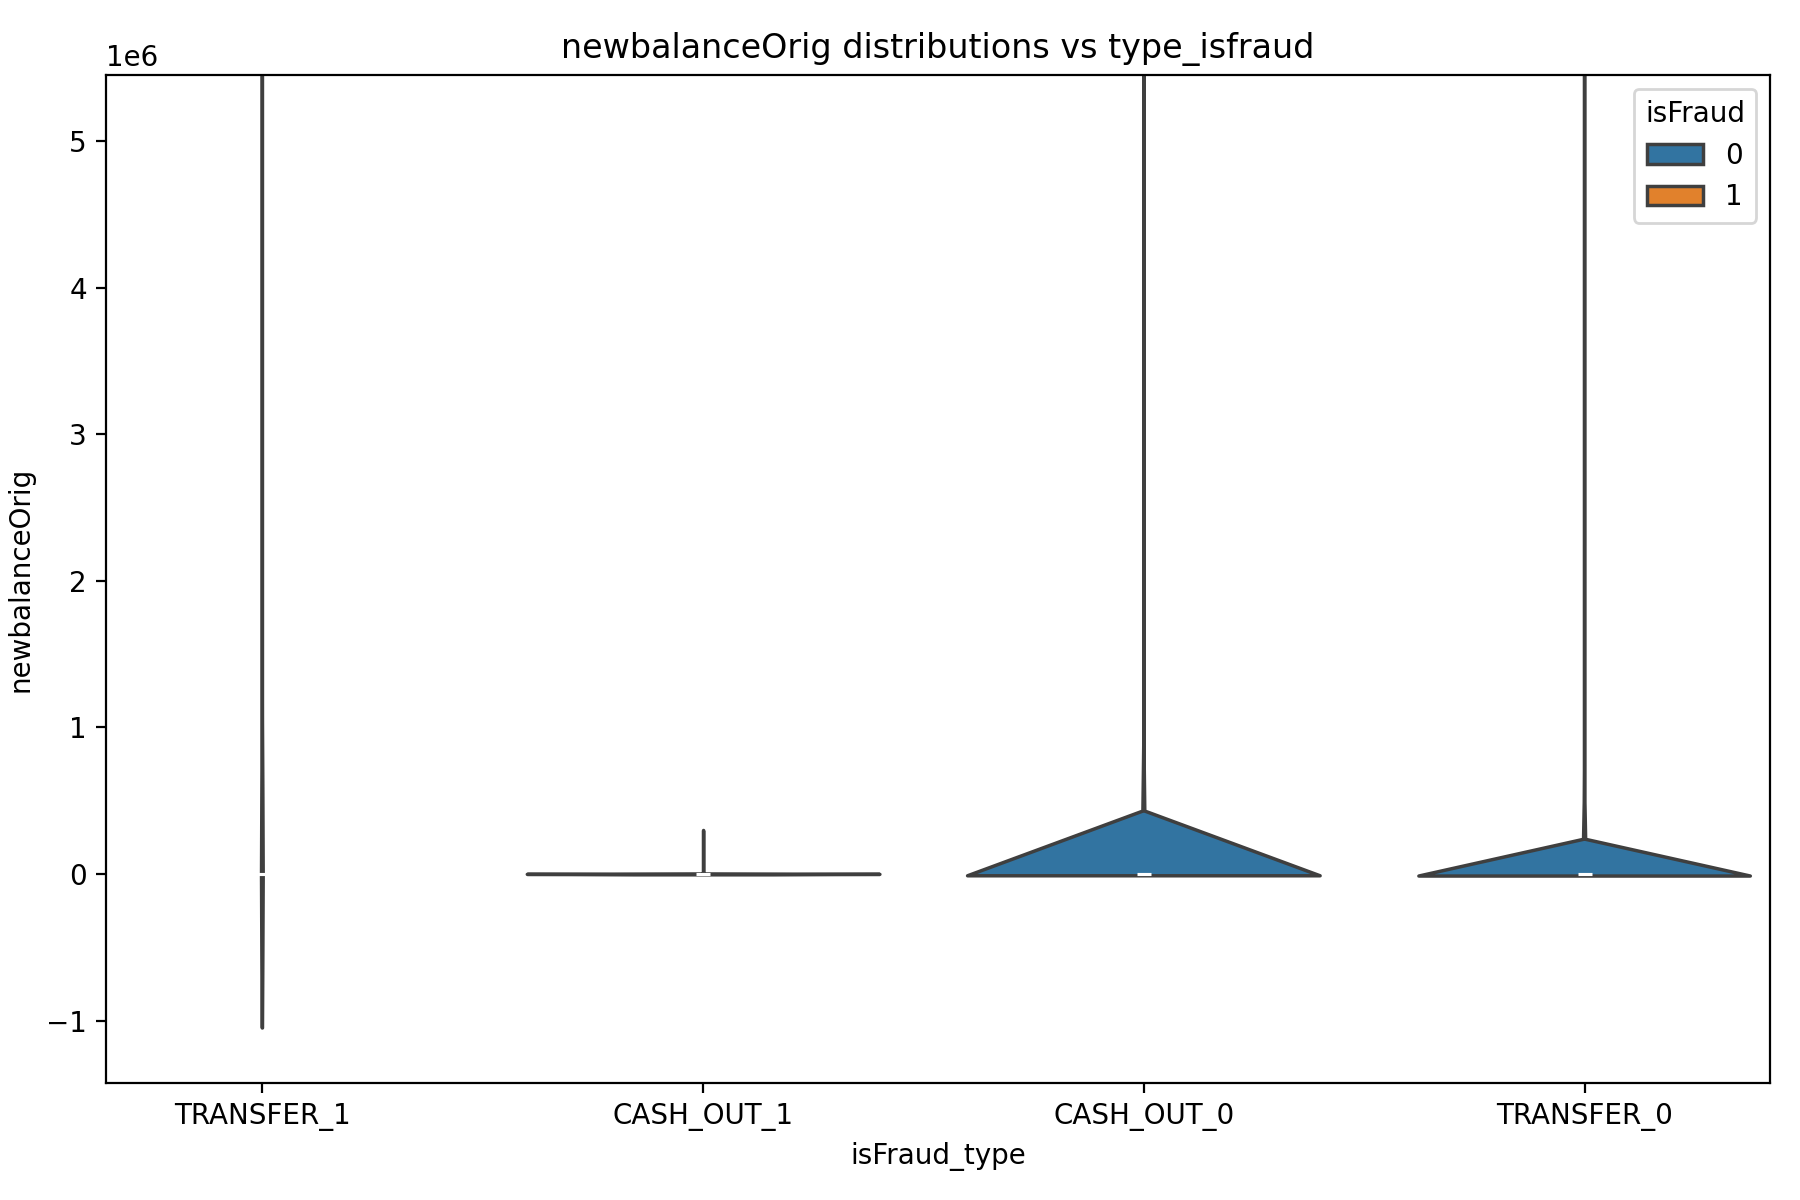

In [76]:
y = 'newbalanceOrig'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- При выводе мошенники, в основном, не оставляли баланса на счете.
- При переводе мошенники имели разные значения остатков на счете, без заметных тенденции.
- Честные сделки сконцентрированы в значениях < 0.5e6 и для выводов и для переводов.
- При мошенническом переводе, у отправителя бывали случаи с отрицательным финальным балансом. Во всех остальных случаях, отрицательных значении не было.

<IPython.core.display.Javascript object>


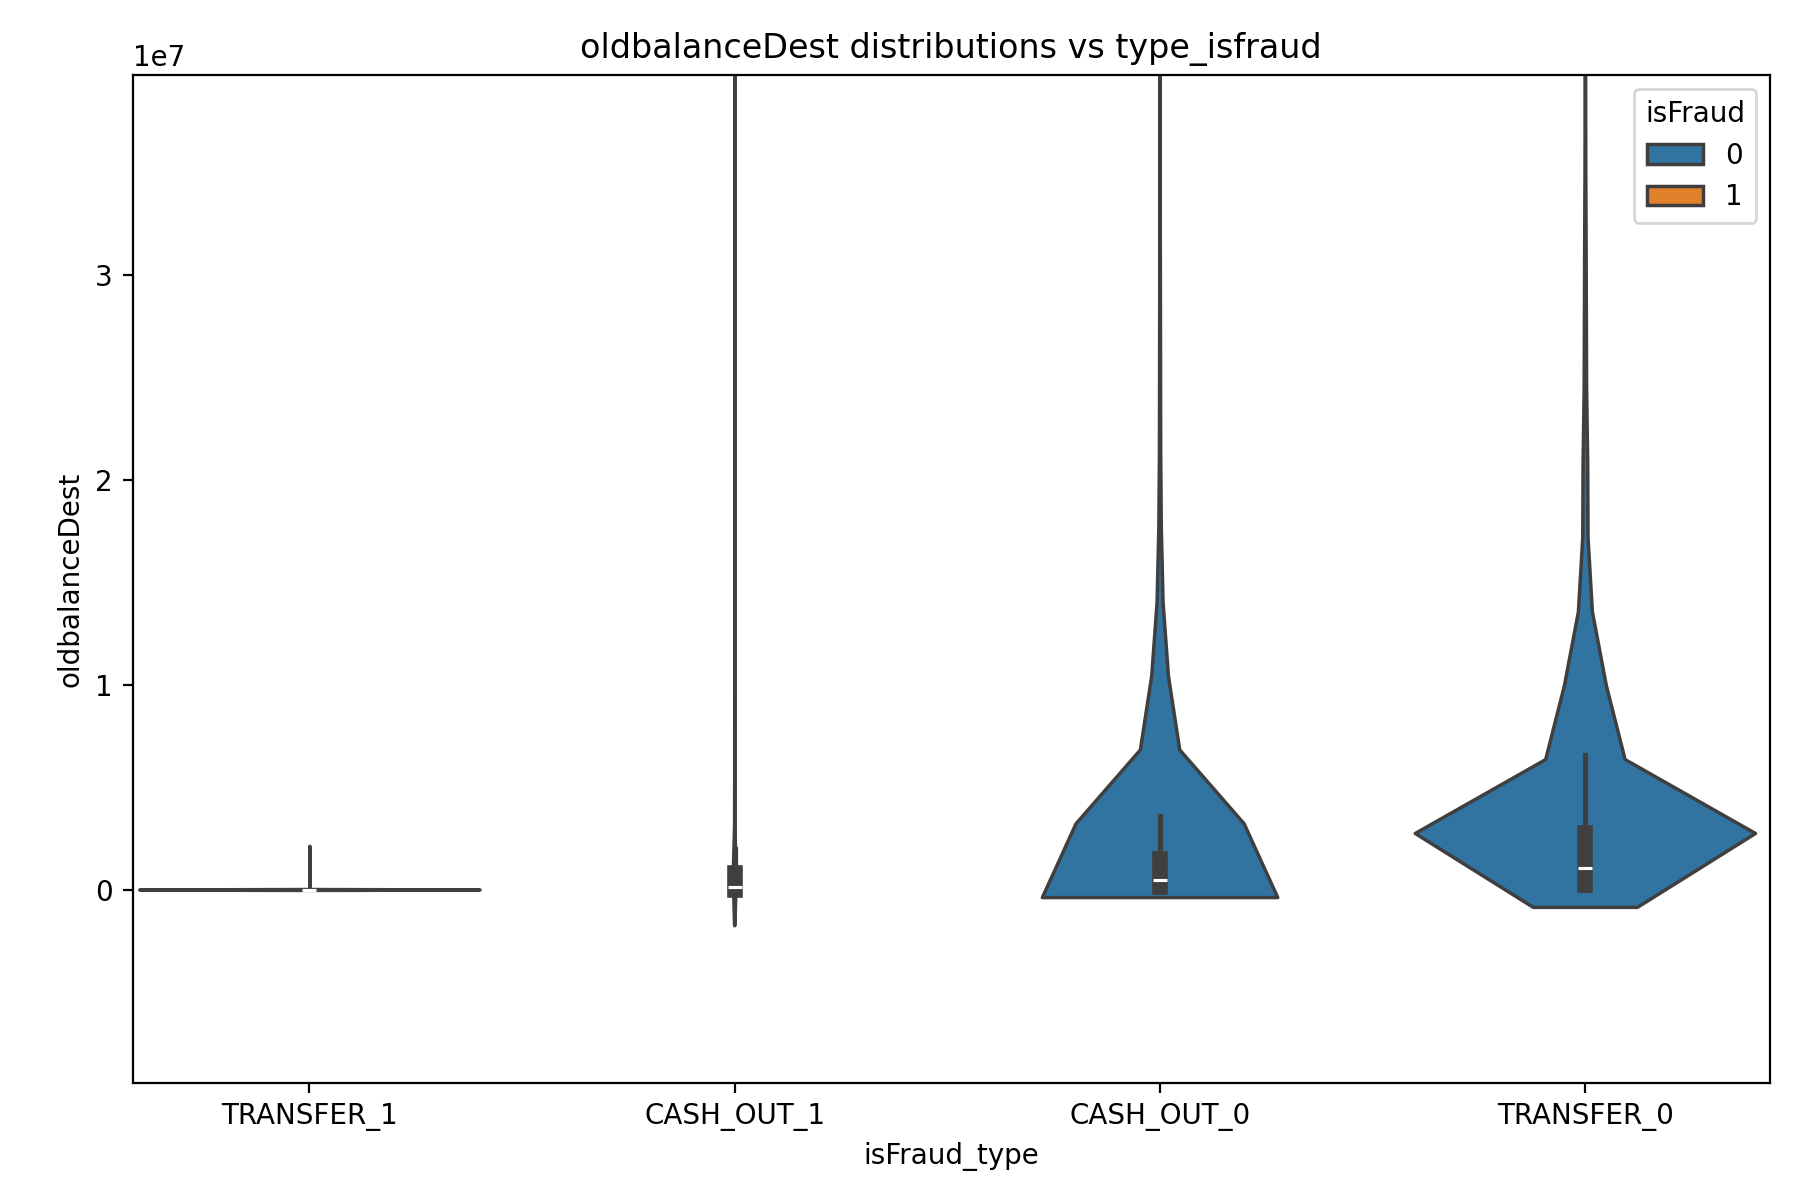

In [77]:
y = 'oldbalanceDest'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- При мошенническом переводе изначальный баланс получателя зачастую 0. При выводе - тоже, но там больше вариативнсти и аутлаеров.
- При мошенническом выводе бывают отрицательные изначальные балансы у получателей, во всех остальных кейсах только положительные.
- Изначальные балансы получателей при добросовестных транзациях распределены более нормально, с усеченной отрицательной частью.

<IPython.core.display.Javascript object>


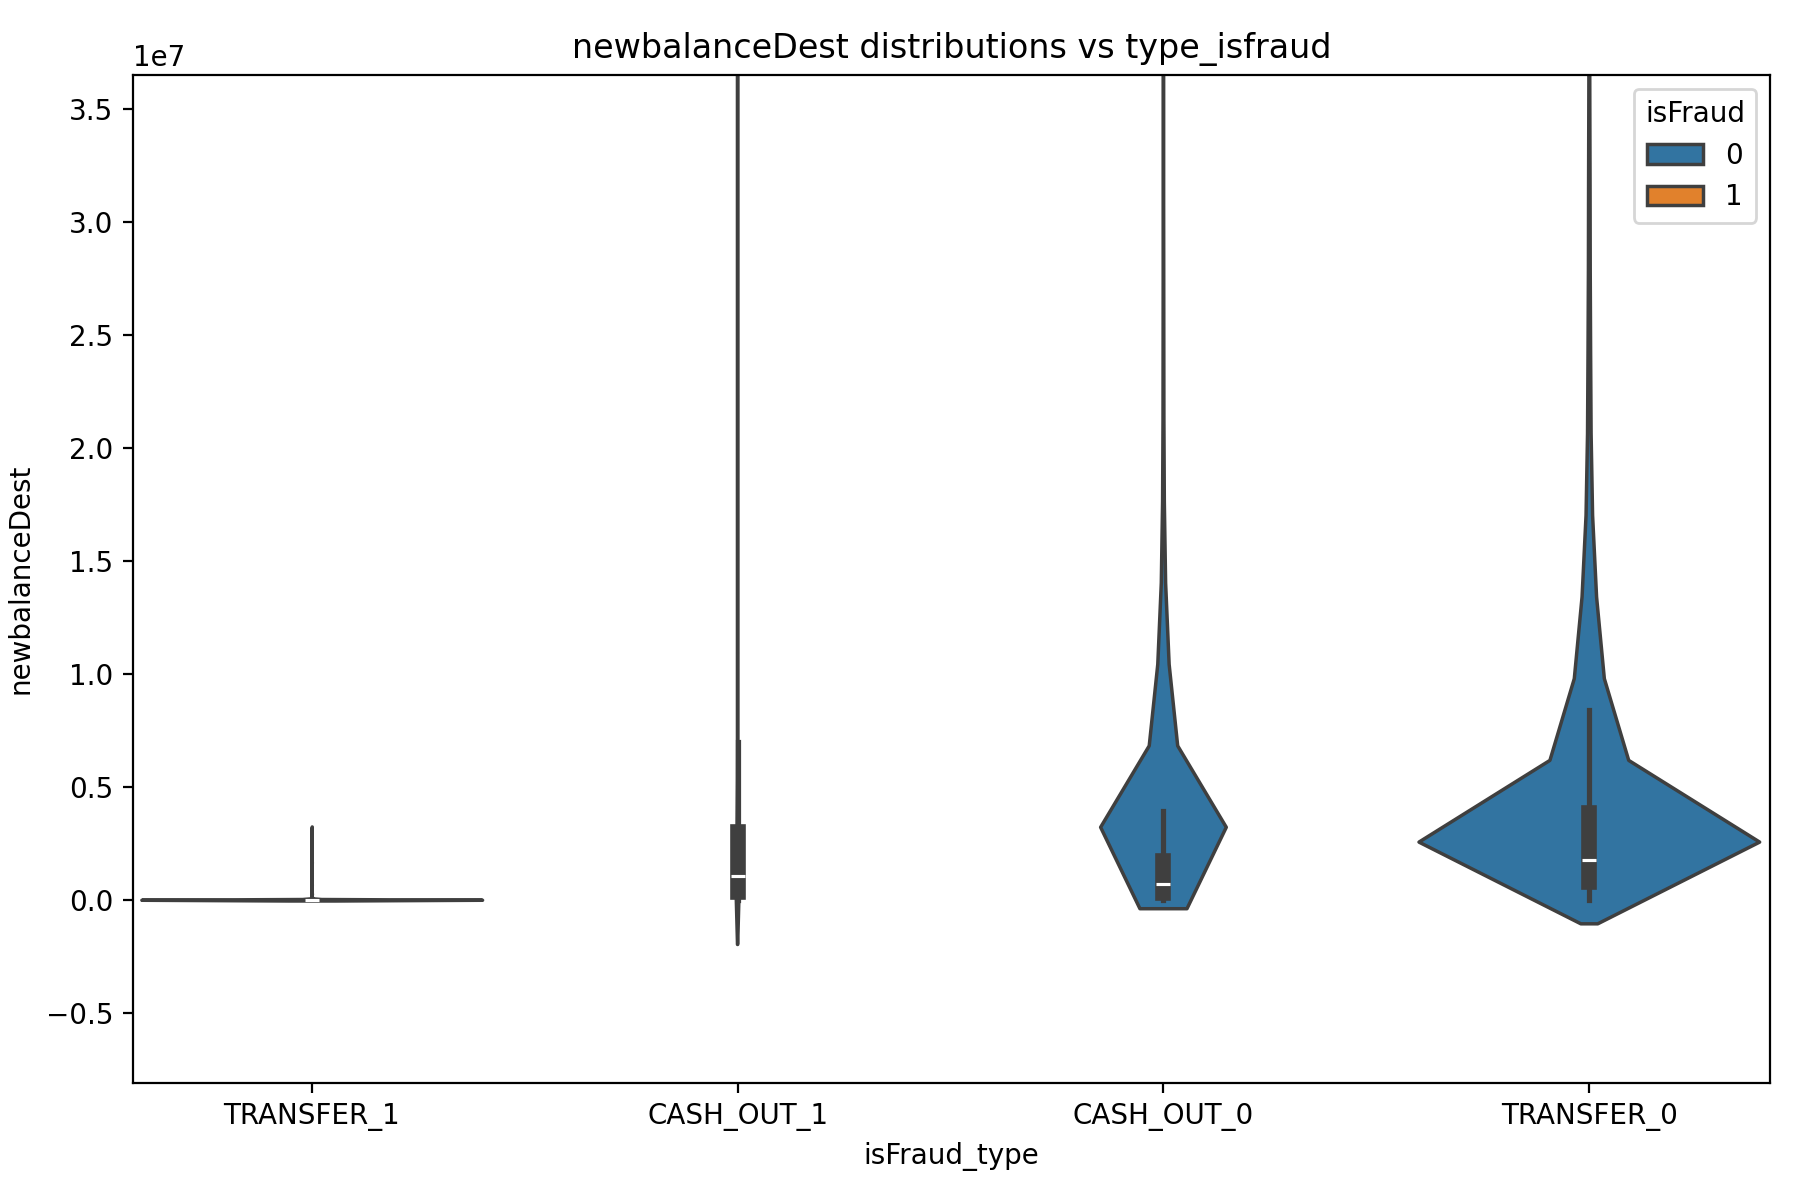

In [78]:
y = 'newbalanceDest'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- С финальными балансами получаетелей аналогично, как с изначальными балансами (сверху). 

<IPython.core.display.Javascript object>


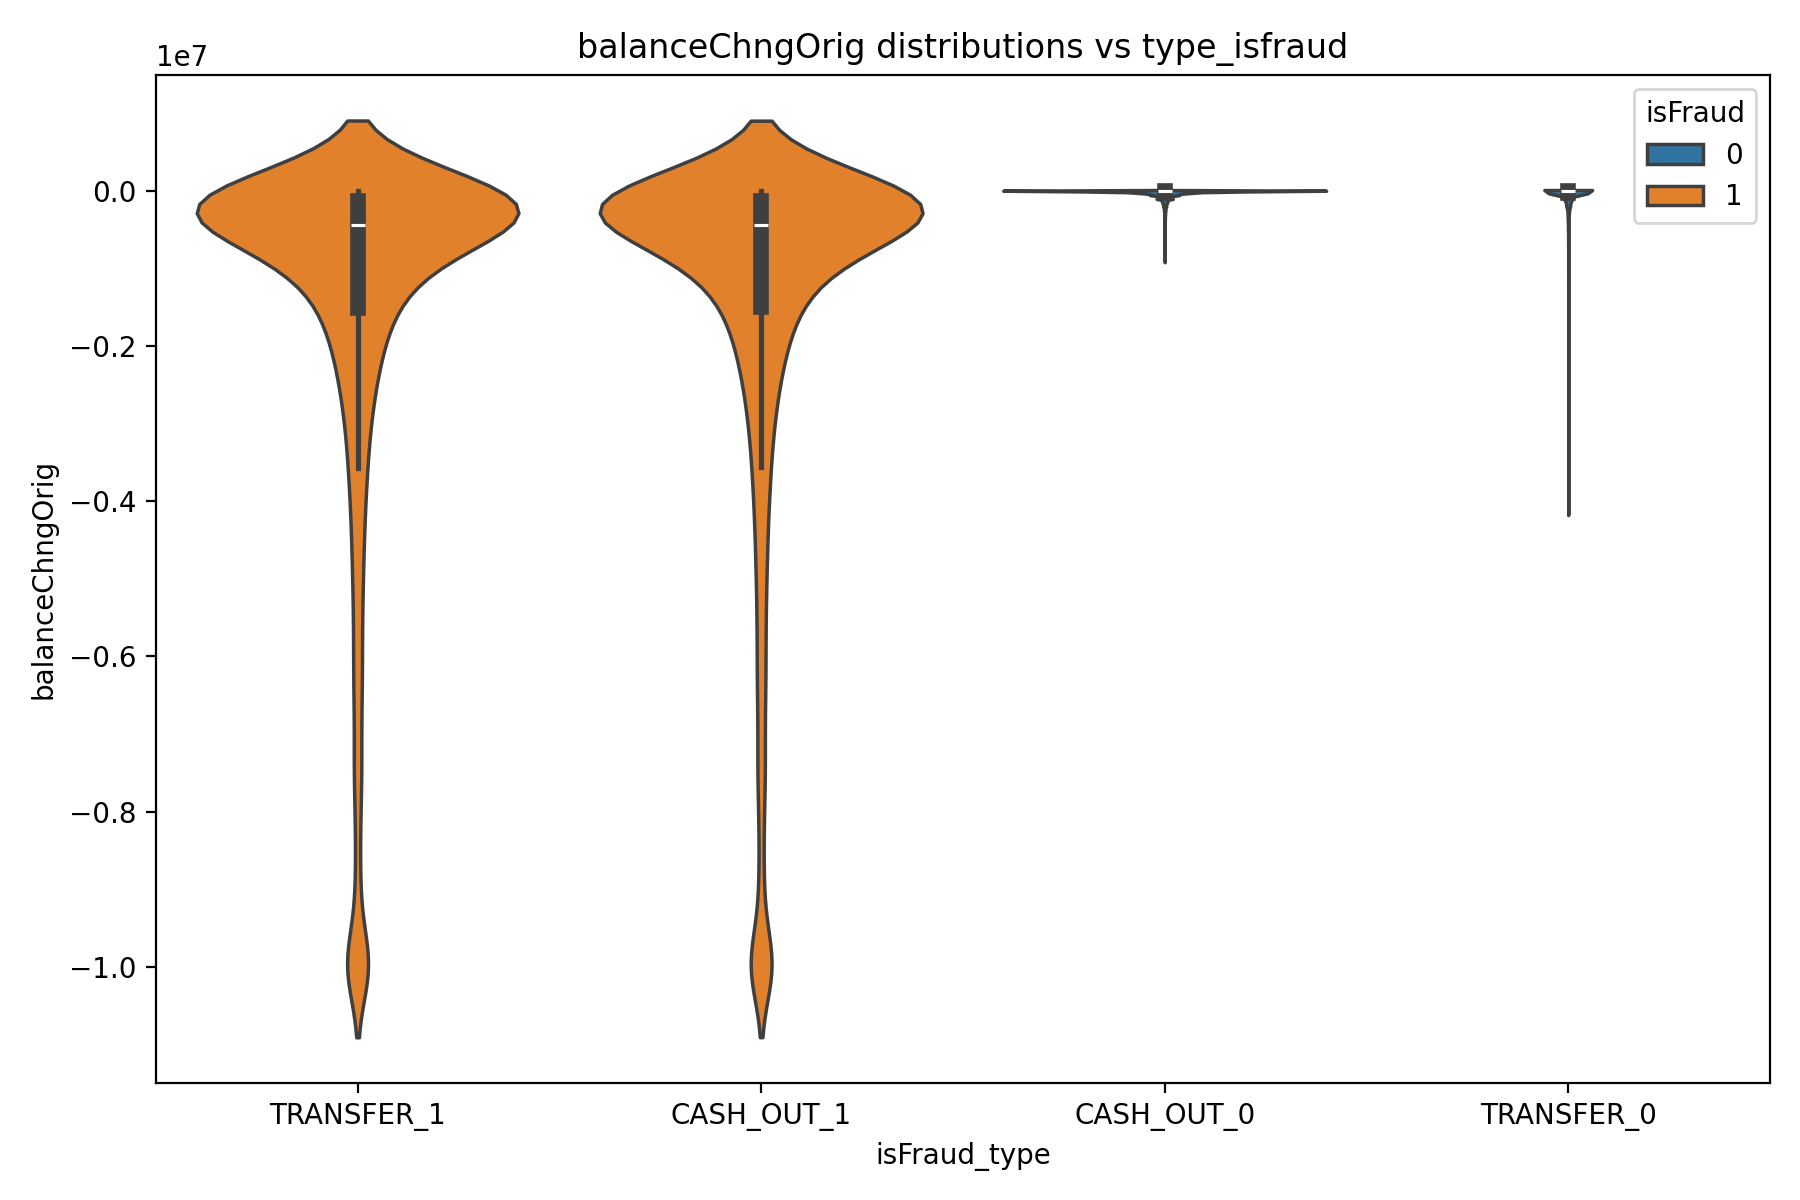

In [86]:
y = 'balanceChngOrig'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- Изменение баланса отправителя при мошенническом переводе явно перекашивает в отрицательную сторону. Большое изменение баланса отправителя подсказывает о подозрительности сделки.
- В мошеннических схемах бывает положительное изменение, в то время как в честных сделках всегда у отправителя уменьшаются деньги.

<IPython.core.display.Javascript object>


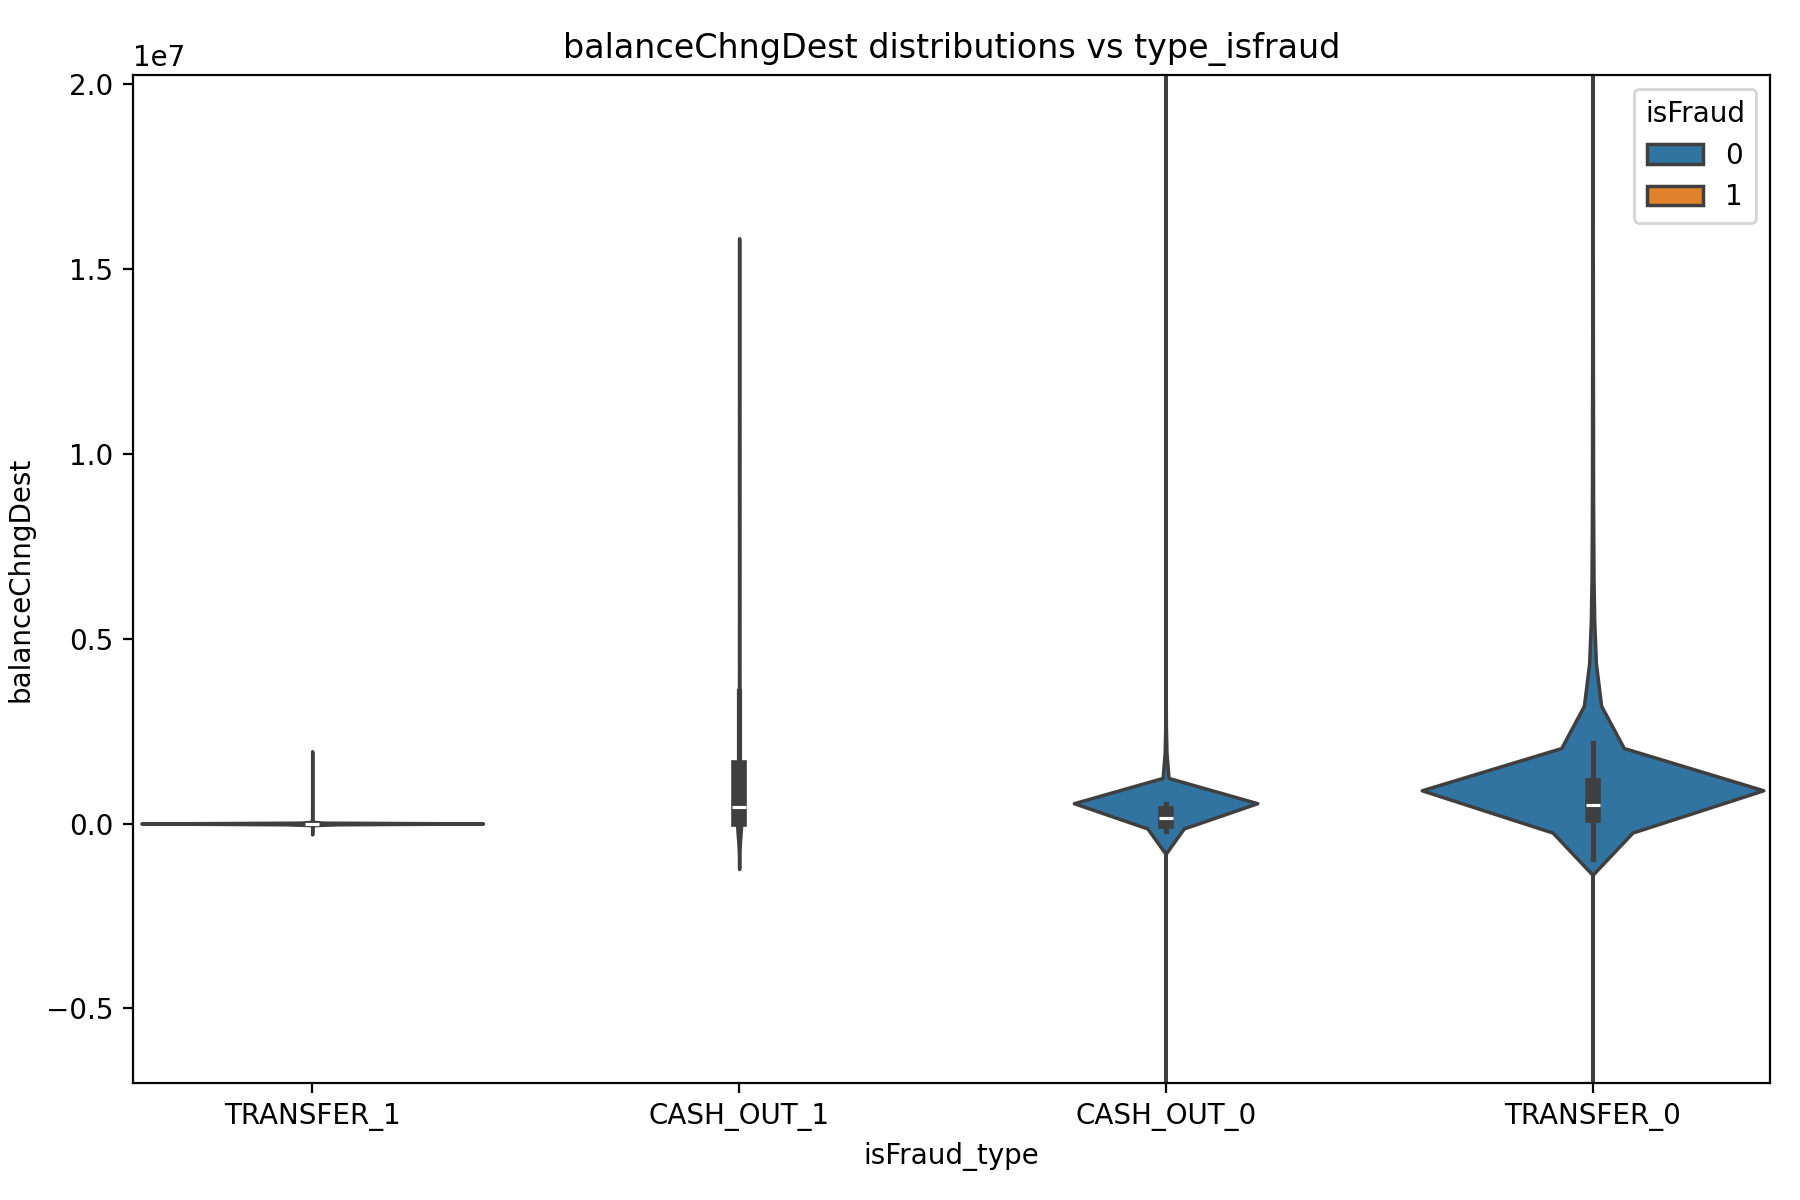

In [80]:
y = 'balanceChngDest'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- Мошеннические переводы в основном не меняют баланса получателя, склонны в сторону положительного.
- Мошеннические выводы более распределены, также склонны к позитивному изменению получателя.
- При честных переводах, распределения более нормальные в обоих типах, около 0.

<IPython.core.display.Javascript object>


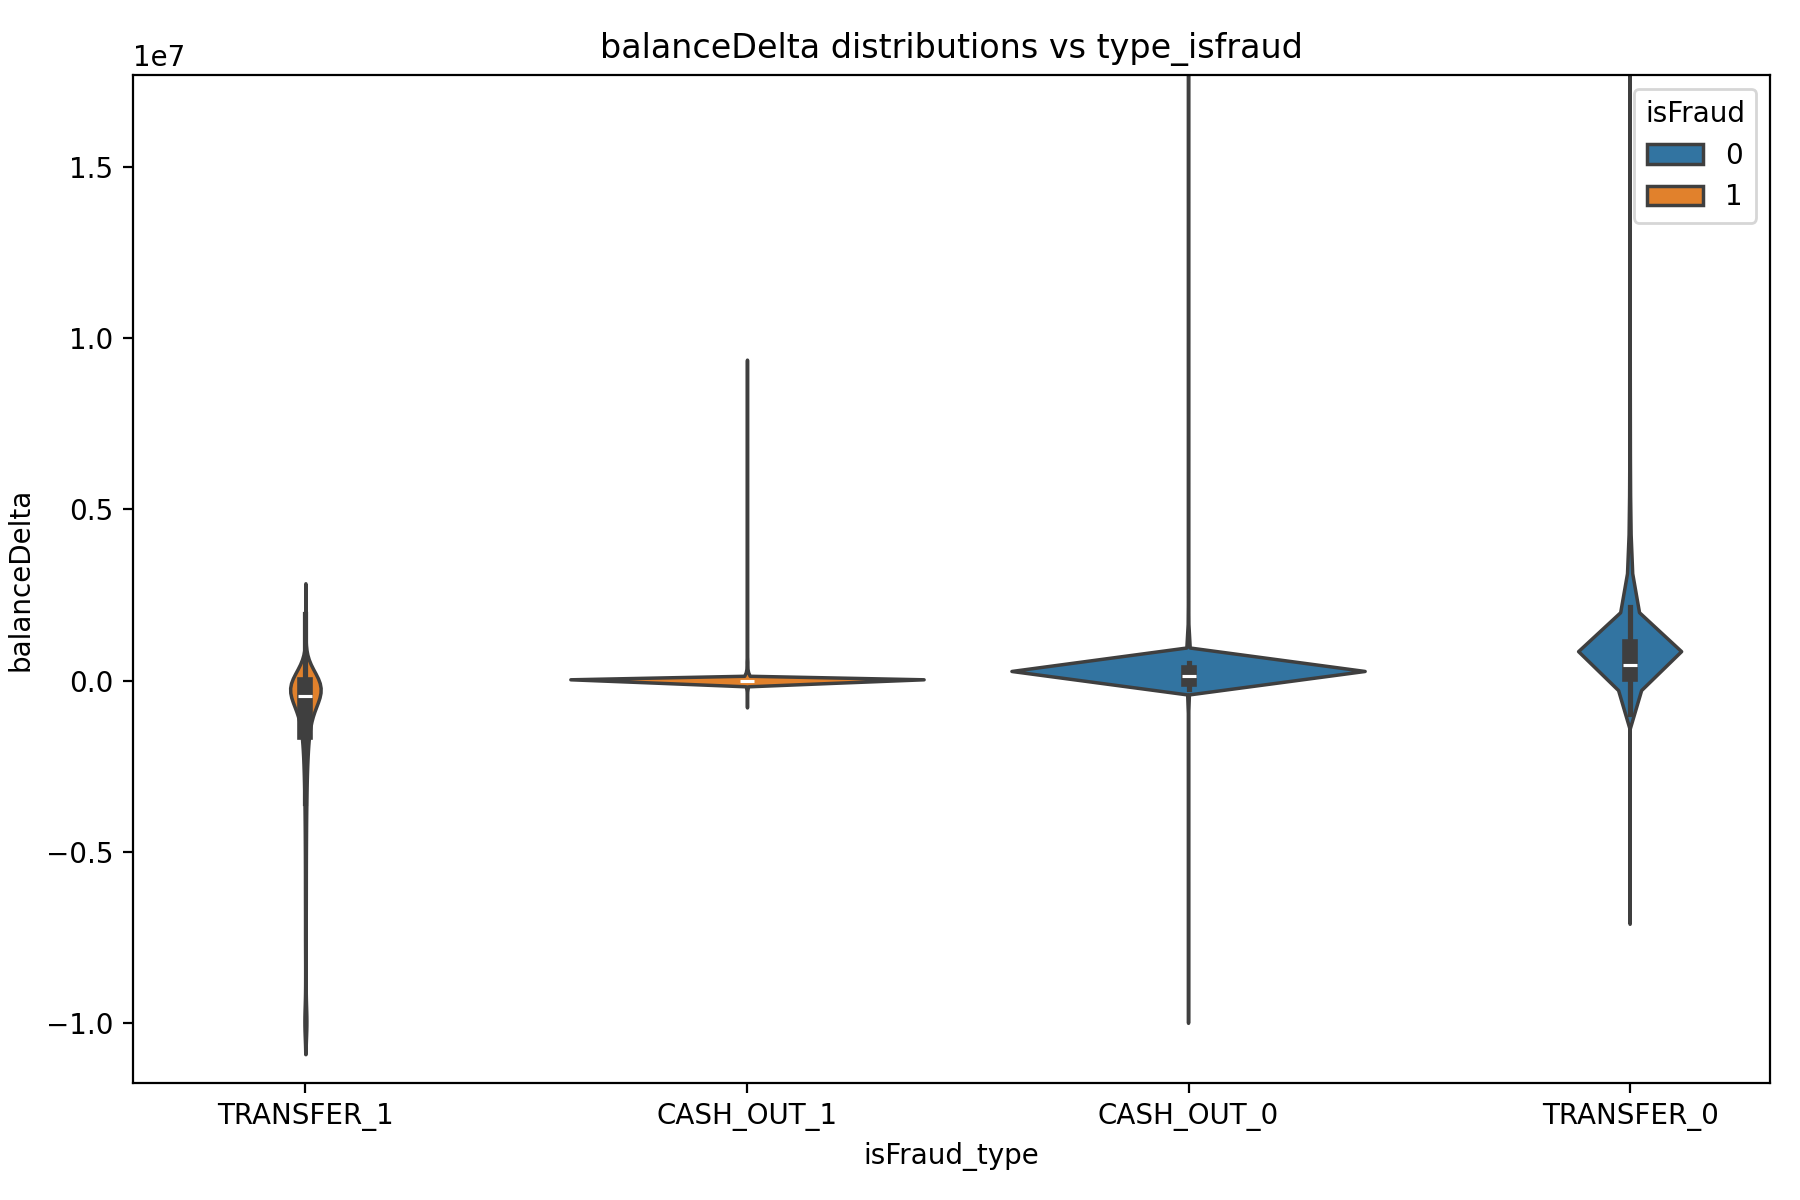

In [81]:
y = 'balanceDelta'

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=y)
ax.set_title(f'{y} distributions vs type_isfraud')
plt.tight_layout();


- В мошеннических переводах, дельта баланса склонна к отрицательному, что может говорить о системных, мошеннических схемах. 
- При мошеннических выводах, дельта сконцентрирована около 0, с перекосом в положительную сторону. Положительная дельта - это дополнительные деньги пришедшие извне, может быть какие-то выплаты в виде бонусов, поощрении, процентов и тп. которые злоупотребляются.
- Дельты честных сделок - нормально распределены, около 0.

# Feature engineering

## Проверяем распределения различных соотношении

<IPython.core.display.Javascript object>


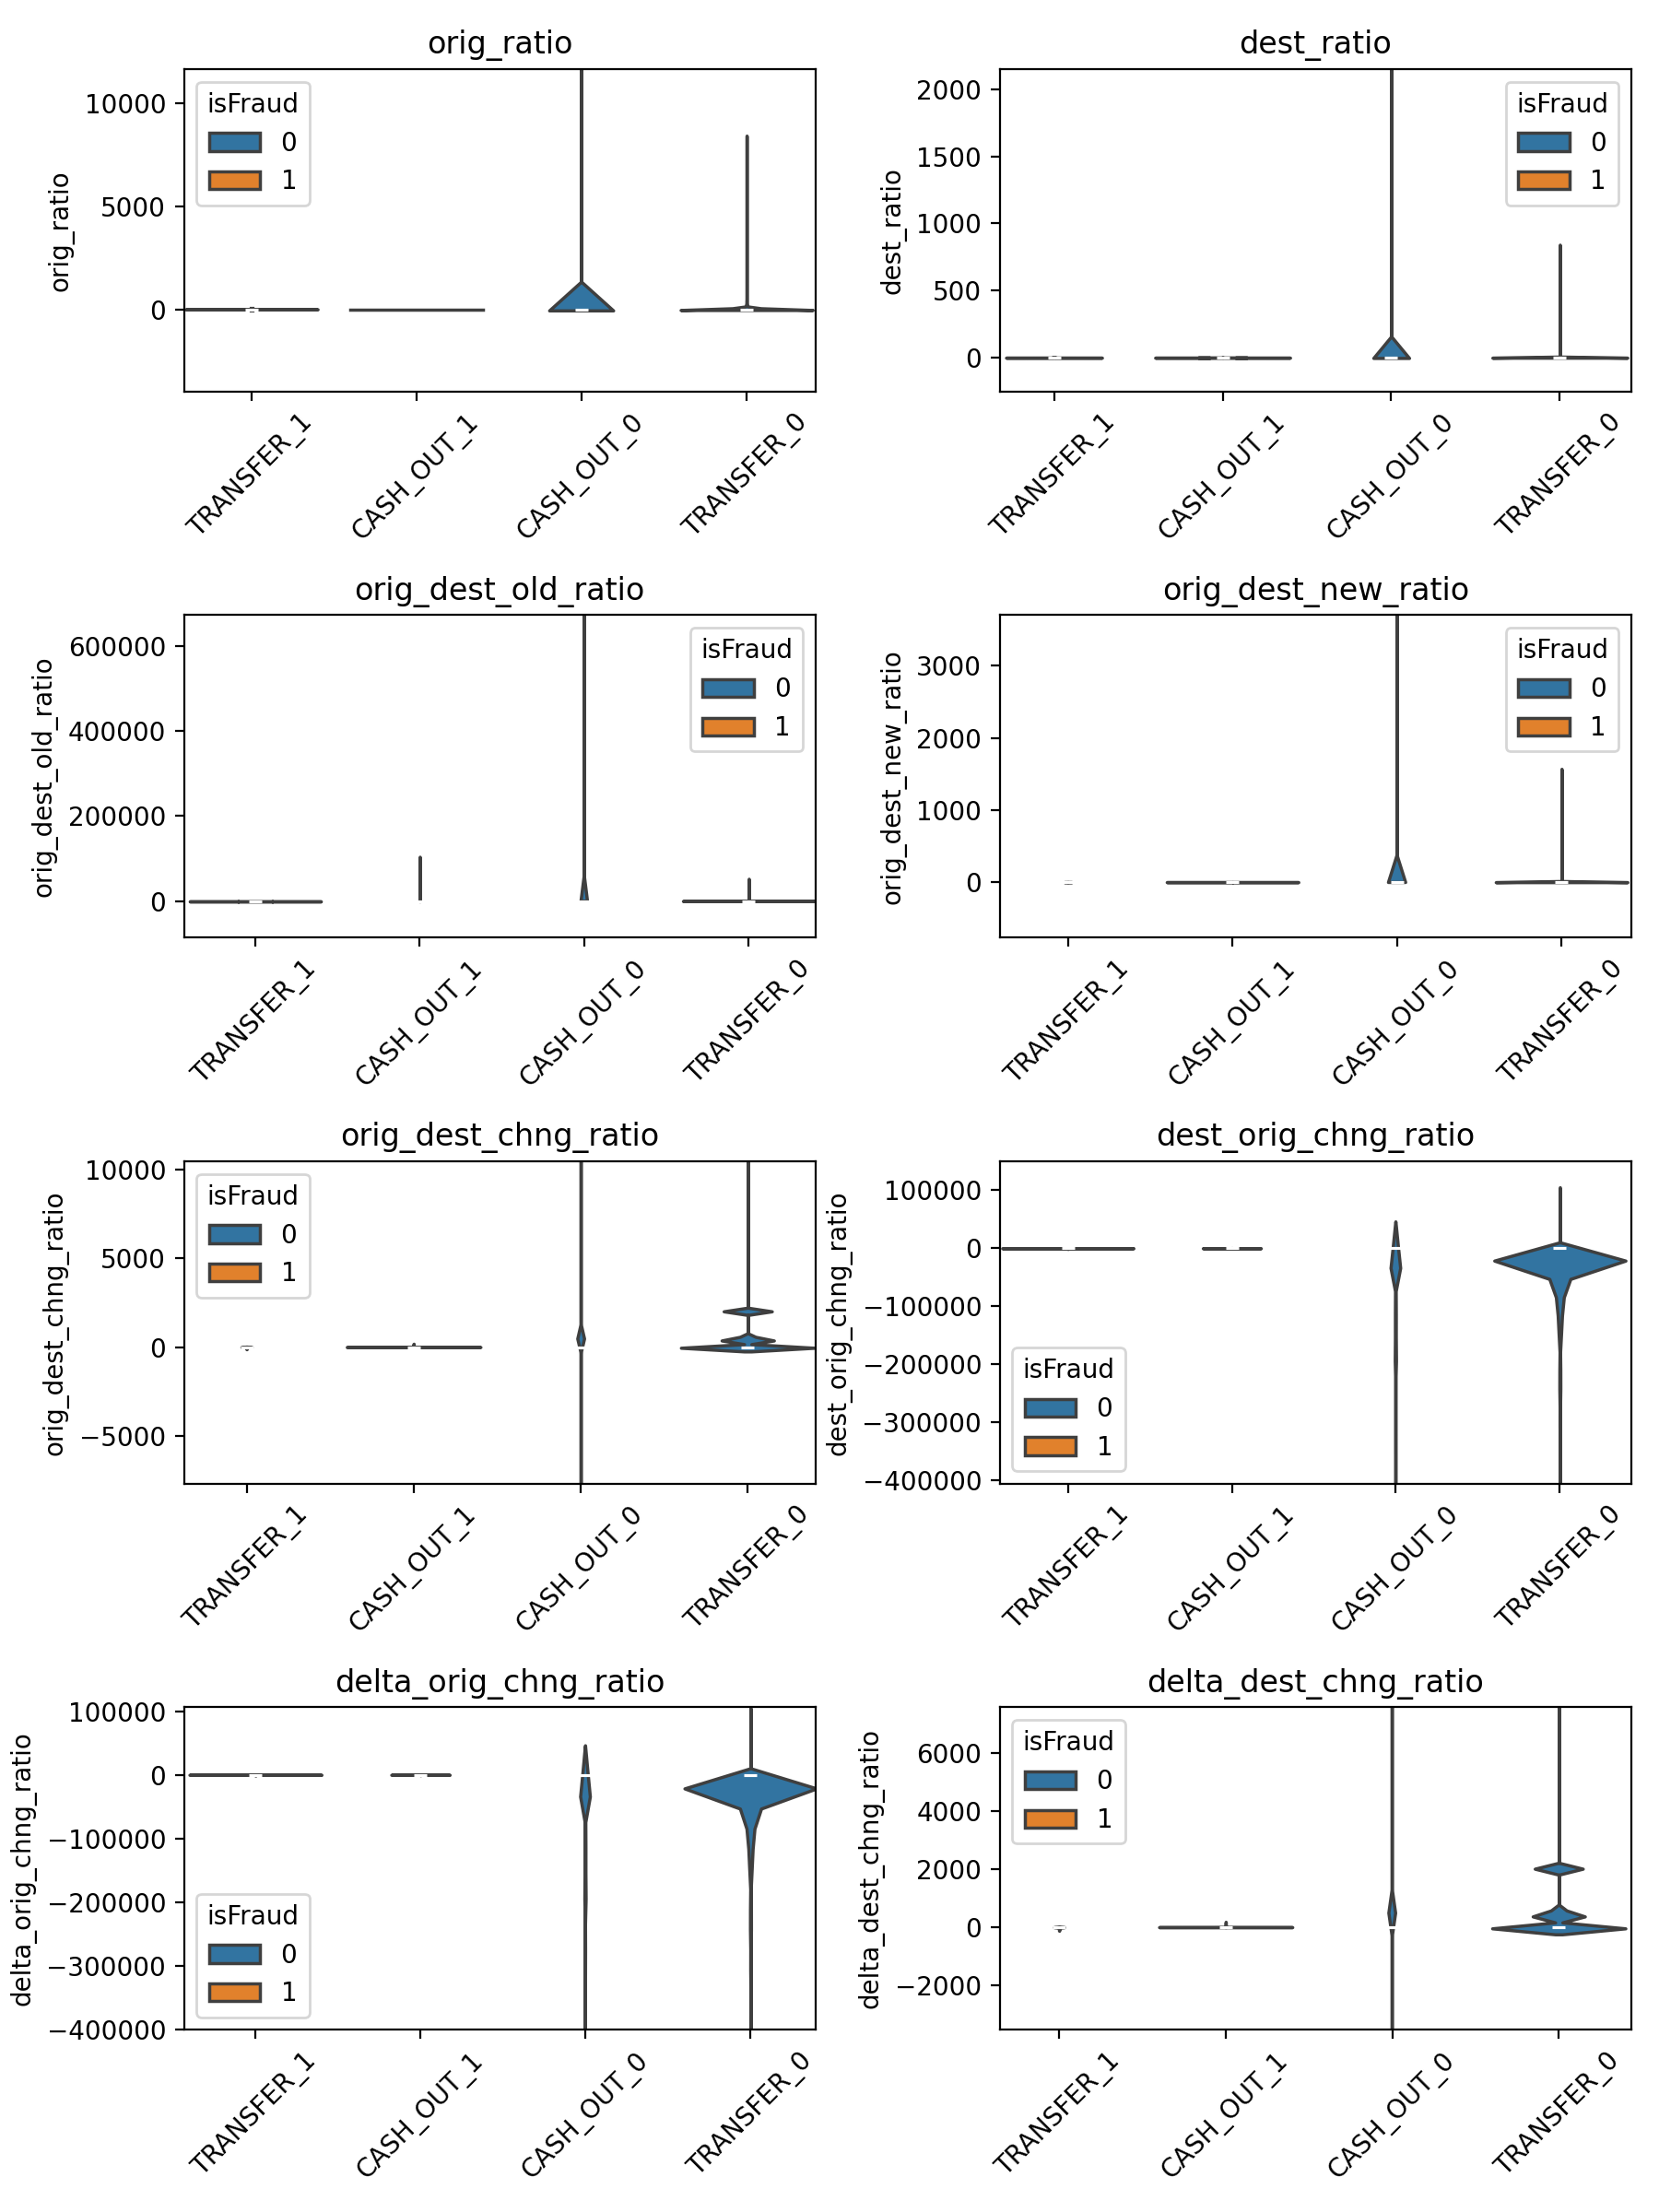

In [115]:
df_only_badtypes['orig_ratio'] = df_only_badtypes['oldbalanceOrg'] / df_only_badtypes['newbalanceOrig']
df_only_badtypes['dest_ratio'] = df_only_badtypes['oldbalanceDest'] / df_only_badtypes['newbalanceDest']
df_only_badtypes['orig_dest_old_ratio'] = df_only_badtypes['oldbalanceOrg'] / df_only_badtypes['oldbalanceDest']
df_only_badtypes['orig_dest_new_ratio'] = df_only_badtypes['newbalanceOrig'] / df_only_badtypes['newbalanceDest']
df_only_badtypes['orig_dest_chng_ratio'] = df_only_badtypes['balanceChngOrig'] / df_only_badtypes['balanceChngDest']
df_only_badtypes['dest_orig_chng_ratio'] = df_only_badtypes['balanceChngDest'] / df_only_badtypes['balanceChngOrig']
df_only_badtypes['delta_orig_chng_ratio'] = df_only_badtypes['balanceDelta'] / df_only_badtypes['balanceChngOrig']
df_only_badtypes['delta_dest_chng_ratio'] = df_only_badtypes['balanceDelta'] / df_only_badtypes['balanceChngDest']

fig, axes = plt.subplots(4, 2, figsize=(9, 12))
axes = axes.flatten()

for ax, col in zip(axes, [
    'orig_ratio',
    'dest_ratio',
    'orig_dest_old_ratio',
    'orig_dest_new_ratio',
    'orig_dest_chng_ratio',
    'dest_orig_chng_ratio',
    'delta_orig_chng_ratio',
    'delta_dest_chng_ratio'
]):
    sns.violinplot(data=df_only_badtypes, x='isFraud_type', hue='isFraud', y=col, ax=ax)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout();


- Все соотношения стремятся к 0, так как у одного из сторон либо начальный баланс 0 либо конечный.
- Оставим delta_orig_chng_ratio и delta_dest_chng_ratio, так как они вбирают в себя всю информацию.

## Аггрегация мерчантов

- Фроды бывают только в переводах и выводах средств.
- Данные уже являются аггрегатами, скорее всего дневными. 
- Отправители в основном уникальные, поэтому нет смысла аггрегировать по ним. 
- Можно аггрегировать по мерчантам для получения информации об их недавних активностях.

- Скользящие окна: 7, 14, 28, 90, 180
- Агрегаты: sum, avg, std, ma_diff_std, count, xtreme_cnt_90, xtreme_cnt_10


- ma_diff_std: разница текущего значения от средней в стандартных отклонениях.
- xtreme_cnt_90: кол-во экстримальных значении (выше 90% квантиля) в окне
- xtreme_cnt_10: кол-во экстримальных значении (ниже 10% квантиля) в окне

In [3]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df['balanceChngOrig'] = (df['newbalanceOrig'] - df['oldbalanceOrg'])
df['balanceChngDest'] = (df['newbalanceDest'] - df['oldbalanceDest'])
df['balanceDelta'] = df['balanceChngOrig'] + df['balanceChngDest']
df['delta_orig_chng_ratio'] = df['balanceDelta'] / df['balanceChngOrig']
df['delta_dest_chng_ratio'] = df['balanceDelta'] / df['balanceChngDest']


- Аггрегация мерчантов с двумя или более записями производилась в отдельном файле counting_aggregates_multiproc.py - в целях мультипроцессинга. 
- Аггрегация одиночных мерчантов ниже.

In [4]:
v_c = df['nameDest'].value_counts()
dests_alone = v_c[v_c == 1].index.values
df_alone = df[df['nameDest'].isin(dests_alone)]

columns_to_agg = [
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'balanceChngOrig',
    'balanceChngDest',
    'balanceDelta',
    'delta_orig_chng_ratio',
    'delta_dest_chng_ratio'
]

win_sizes = [7, 14, 28, 90, 180]

for col in columns_to_agg:
    for win_size in win_sizes:
        df_alone[f'{col}_{win_size}_sum'] = df_alone[col]
        df_alone[f'{col}_{win_size}_avg'] = df_alone[col]
        df_alone[f'{col}_{win_size}_std'] = None
        df_alone[f'{col}_{win_size}_count'] = 1
        df_alone[f'{col}_{win_size}_ma_diff_std'] = None
        df_alone[f'{col}_{win_size}_xtreme_cnt_90'] = 0
        df_alone[f'{col}_{win_size}_xtreme_cnt_10'] = 0
        
        df_alone[f'{col}_{win_size}_sum'] = df_alone[f'{col}_{win_size}_sum'].astype(float)
        df_alone[f'{col}_{win_size}_avg'] = df_alone[f'{col}_{win_size}_avg'].astype(float)
        df_alone[f'{col}_{win_size}_std'] = df_alone[f'{col}_{win_size}_std'].astype(float)
        df_alone[f'{col}_{win_size}_count'] = df_alone[f'{col}_{win_size}_count'].astype(float)
        df_alone[f'{col}_{win_size}_ma_diff_std'] = df_alone[f'{col}_{win_size}_ma_diff_std'].astype(float)
        df_alone[f'{col}_{win_size}_xtreme_cnt_90'] = df_alone[f'{col}_{win_size}_xtreme_cnt_90'].astype(float)
        df_alone[f'{col}_{win_size}_xtreme_cnt_10'] = df_alone[f'{col}_{win_size}_xtreme_cnt_10'].astype(float)


## One hot encoding типа

In [6]:
df['is_transfer'] = df['type'] == 'TRANSFER'
df['is_cash_out'] = df['type'] == 'CASH_OUT'


In [7]:
all_columns = df.columns.tolist()
meta_columns = [
    'step',
    'nameOrig',
    'nameDest'
]
y_column = 'isFraud'
x_columns = [a for a in all_columns if a not in (meta_columns + ['isFraud', 'isFlaggedFraud', 'type'])]


## Важность фичей

In [101]:
early_rounds = 300
splits_n = 5

df_train, df_valid = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[y_column]
)

In [103]:
def train_plain_model(x_columns):
    plain_params = {
        'n_estimators': 100, 
        'learning_rate': 0.1, 
        'max_depth': 100, 
        'num_leaves': 250, 
        'min_child_samples': 25, 
        'min_child_weight': 0.1, 
        'subsample': 0.5, 
        'subsample_freq': 1, 
        'colsample_bytree': 0.6, 
        'reg_alpha': 1.35, 
        'reg_lambda': 32, 
        'max_bin': 500, 
        'feature_fraction': 0.15, 
        'bagging_fraction': 0.85, 
        'bagging_freq': 5, 
        'scale_pos_weight': 35,
        'verbose': -1,
    }

    data_xy = df_train[x_columns + [y_column]]
    target_col = y_column
    param = plain_params

    splits = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    X = data_xy.drop([target_col], axis=1)
    y = data_xy[target_col]

    for i, (train_index, test_index) in enumerate(splits.split(X, y)):
        train = data_xy.iloc[train_index]
        test = data_xy.iloc[test_index]

        X_train = train.drop([target_col], axis=1)
        y_train = train[target_col]
        X_test = test.drop([target_col], axis=1)
        y_test = test[target_col]
        model = lgb.LGBMClassifier(**param)
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  callbacks=[
                        lgb.early_stopping(stopping_rounds=early_rounds),
                    ]
                  )

        y_scores_train = model.predict_proba(X_train)[:, 1]
        y_scores_test = model.predict_proba(X_test)[:, 1]

        precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
        pr_auc_train = auc(recall_train, precision_train)
        precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)
        pr_auc_test = auc(recall_test, precision_test)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)

        penalty = abs(pr_auc_train - pr_auc_test)

        composite_metric = pr_auc_test

        print(f'Split {i}:')
        print('Train PR-AUC:', pr_auc_train)
        print('Test PR-AUC:', pr_auc_test)
        print('Penalty:', penalty)
        print('Train F1:', f1_train)
        print('Test F1:', f1_test)
        print('metric', composite_metric, '\n')
        
    return model


model = train_plain_model(x_columns)


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000543446
Split 0:
Train PR-AUC: 0.9991117828035208
Test PR-AUC: 0.9983361820061375
Penalty: 0.0007756007973832579
Train F1: 0.9847306251800634
Test F1: 0.9814814814814815
metric 0.9983361820061375 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000622183
Split 1:
Train PR-AUC: 0.9995660216051901
Test PR-AUC: 0.9936861654018513
Penalty: 0.005879856203338862
Train F1: 0.9832949308755761
Test F1: 0.9663182346109176
metric 0.9936861654018513 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000709426
Split 2:
Train PR-AUC: 0.9985960611066125
Test PR-AUC: 0.9835696540469667
Penalty: 0.015026407059645752
Train F1: 0.9835971223021582
Test F1: 0.958236658932714

- Простая модель натренировалась достаточно хорошо, без переобучения. 
- Используя эту модель можем посмотреть на важность фичей.

<IPython.core.display.Javascript object>


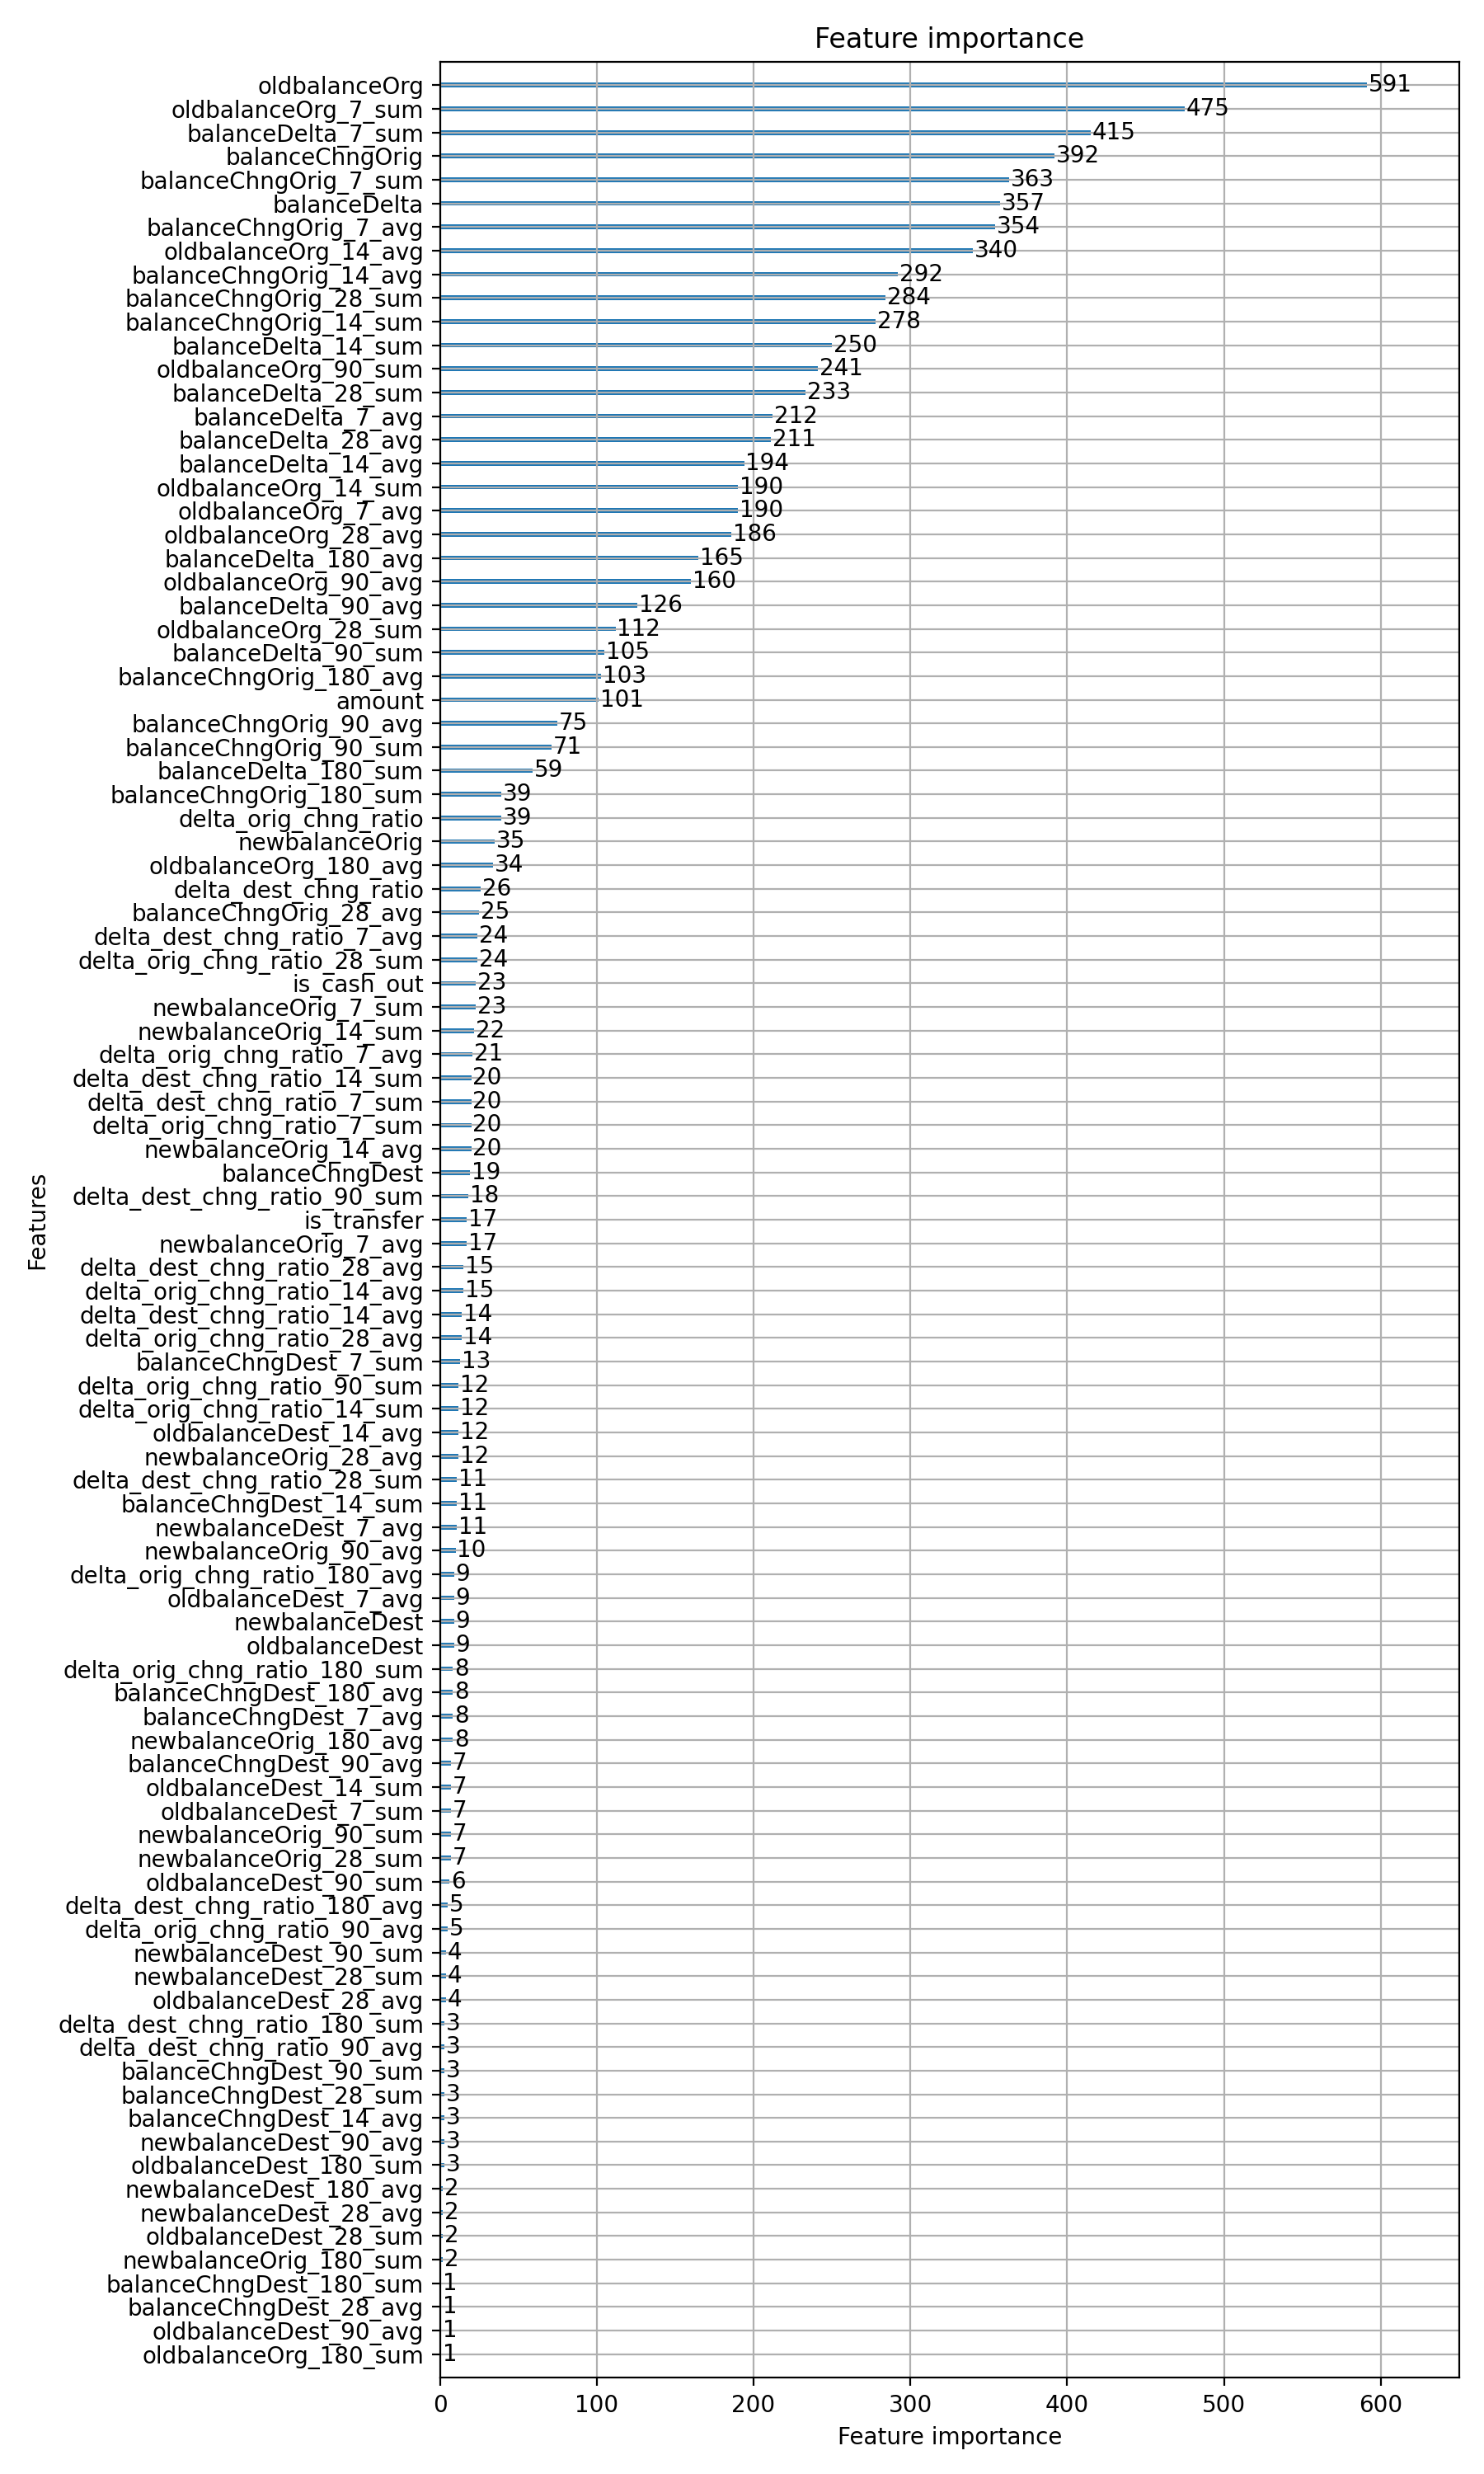

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(9, 15))
lgb.plot_importance(model, ax=ax)
plt.tight_layout();


- На графике можно заметить как падает информативность фичей начиная с balanceChngOrig_180_sum - она является первой фичей со значением важности < 50
- Оставим фичи с важностью более 50. 

In [108]:
def get_important_features(model, threshold):
    importance_df = pd.DataFrame({
        'Feature': model.feature_name_,
        'Importance': model.feature_importances_
    })
    return importance_df[importance_df['Importance'] >= threshold].sort_values(by='Importance', ascending=False)['Feature'].tolist()


important_features = get_important_features(model, 50)
len(important_features)


30

# Model training

## Tuning

In [111]:
def objective(trial, data_xy, target_col):
    param = {
        'metric': 'auc',
        'objective': 'binary',
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e1, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_categorical("subsample_freq", [1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-1, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-1, 100, log=True),
        'max_bin': trial.suggest_int('max_bin', 100, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 100, log=True),  # Added for imbalance
        'verbose': -1,
        'n_jobs': 10
    }
    splits = StratifiedKFold(n_splits=splits_n, shuffle=True, random_state=42)
    cv_scores = []
   
    X = data_xy.drop([target_col], axis=1)
    y = data_xy[target_col]
   
    for i, (train_index, test_index) in enumerate(splits.split(X, y)):
        train = data_xy.iloc[train_index]
        test = data_xy.iloc[test_index]
       
        X_train = train.drop([target_col], axis=1)
        y_train = train[target_col]
        X_test = test.drop([target_col], axis=1)
        y_test = test[target_col]
        model = lgb.LGBMClassifier(**param)
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  callbacks=[
                        lgb.early_stopping(stopping_rounds=early_rounds),
                    ]
                  )
       
        y_scores_train = model.predict_proba(X_train)[:, 1]
        y_scores_test = model.predict_proba(X_test)[:, 1]
       
        precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
        pr_auc_train = auc(recall_train, precision_train)
        precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)
        pr_auc_test = auc(recall_test, precision_test)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)
        
        penalty = abs(pr_auc_train - pr_auc_test)
       
        composite_metric = pr_auc_test
        
        print(f'Split {i}:')
        print('Train PR-AUC:', pr_auc_train)
        print('Test PR-AUC:', pr_auc_test)
        print('Penalty:', penalty)
        print('Train F1:', f1_train)
        print('Test F1:', f1_test)
        print('metric', composite_metric, '\n')
       
        cv_scores.append(composite_metric)
   
    cv_avg = np.mean(cv_scores)
    return cv_avg


In [112]:
study = optuna.create_study(
    direction="maximize",
    study_name='main_new',
    storage="sqlite:///optuna_study.db",
    load_if_exists=True
)

func = lambda trial: objective(trial, df_train[important_features + [y_column]], y_column)
study.optimize(func, n_trials=100)


[I 2025-09-17 06:45:00,024] A new study created in RDB with name: main_new


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[229]	valid_0's auc: 0.998986
Split 0:
Train PR-AUC: 0.8511946779931716
Test PR-AUC: 0.8691382319680045
Penalty: 0.017943553974832938
Train F1: 0.8079847908745247
Test F1: 0.818407960199005
metric 0.8691382319680045 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[249]	valid_0's auc: 0.997157
Split 1:
Train PR-AUC: 0.8312823987469098
Test PR-AUC: 0.7557712068568172
Penalty: 0.07551119189009259
Train F1: 0.8247685924034471
Test F1: 0.7927927927927928
metric 0.7557712068568172 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[253]	valid_0's auc: 0.998022
Split 2:
Train PR-AUC: 0.7332309636915801
Test PR-AUC: 0.8340541214790925
Penalty: 0.10082315778751239
Train F1: 0.8254167977351369
Test F1: 0.7989949748743719
metric 0.8340541214790925 

Training until v

[I 2025-09-17 06:46:20,352] Trial 0 finished with value: 0.770507193625267 and parameters: {'n_estimators': 253, 'learning_rate': 0.124518650971417, 'max_depth': 4, 'num_leaves': 46, 'min_child_samples': 30, 'min_child_weight': 0.017930492987472953, 'subsample': 0.8985093728530053, 'subsample_freq': 1, 'colsample_bytree': 0.4100176662105979, 'reg_alpha': 0.16062882322212174, 'reg_lambda': 0.3301566175902244, 'max_bin': 100, 'feature_fraction': 0.15503343685022372, 'bagging_fraction': 0.18398631206742205, 'bagging_freq': 1, 'scale_pos_weight': 1.7205933625111824}. Best is trial 0 with value: 0.770507193625267.


Split 4:
Train PR-AUC: 0.7136981118223678
Test PR-AUC: 0.6920369884904229
Penalty: 0.02166112333194481
Train F1: 0.8202531645569621
Test F1: 0.8055908513341804
metric 0.6920369884904229 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[159]	valid_0's auc: 0.998586
Split 0:
Train PR-AUC: 0.8497441812015333
Test PR-AUC: 0.8626100742825337
Penalty: 0.01286589308100039
Train F1: 0.5013157894736842
Test F1: 0.5032679738562091
metric 0.8626100742825337 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[159]	valid_0's auc: 0.996985
Split 1:
Train PR-AUC: 0.8610013603982895
Test PR-AUC: 0.8118735139878914
Penalty: 0.049127846410398024
Train F1: 0.49934980494148246
Test F1: 0.4665367121507472
metric 0.8118735139878914 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[159]	valid_0's auc: 0.996351
Split 2:
Train

[I 2025-09-17 06:47:43,679] Trial 1 finished with value: 0.8413860794993896 and parameters: {'n_estimators': 159, 'learning_rate': 0.029799575717493042, 'max_depth': 35, 'num_leaves': 68, 'min_child_samples': 21, 'min_child_weight': 0.005585170393863852, 'subsample': 0.47949914521496273, 'subsample_freq': 1, 'colsample_bytree': 0.4319138128708978, 'reg_alpha': 0.3479748170883369, 'reg_lambda': 31.613809602724896, 'max_bin': 100, 'feature_fraction': 0.26195229616448257, 'bagging_fraction': 0.18539018858897688, 'bagging_freq': 1, 'scale_pos_weight': 36.626871731917994}. Best is trial 1 with value: 0.8413860794993896.


Split 4:
Train PR-AUC: 0.8525924615425515
Test PR-AUC: 0.8462964024606418
Penalty: 0.006296059081909777
Train F1: 0.4908649959579628
Test F1: 0.47728726807421623
metric 0.8462964024606418 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[137]	valid_0's auc: 0.996778
Split 0:
Train PR-AUC: 0.8225376565204653
Test PR-AUC: 0.8492542308401931
Penalty: 0.026716574319727848
Train F1: 0.7724992623192682
Test F1: 0.8138424821002387
metric 0.8492542308401931 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[137]	valid_0's auc: 0.98864
Split 1:
Train PR-AUC: 0.8376107785485523
Test PR-AUC: 0.7910824646724658
Penalty: 0.04652831387608647
Train F1: 0.7970014992503748
Test F1: 0.7569528415961306
metric 0.7910824646724658 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[137]	valid_0's auc: 0.994271
Split 2:
Train

[I 2025-09-17 06:48:49,230] Trial 2 finished with value: 0.8286644165911777 and parameters: {'n_estimators': 137, 'learning_rate': 0.030928500981615887, 'max_depth': 73, 'num_leaves': 276, 'min_child_samples': 85, 'min_child_weight': 7.101014797868065, 'subsample': 0.6143332657958357, 'subsample_freq': 1, 'colsample_bytree': 0.6678673014449025, 'reg_alpha': 45.330307852558036, 'reg_lambda': 99.18194300735917, 'max_bin': 100, 'feature_fraction': 0.9941714523857414, 'bagging_fraction': 0.6626242213448843, 'bagging_freq': 3, 'scale_pos_weight': 5.563390556917841}. Best is trial 1 with value: 0.8413860794993896.


Split 4:
Train PR-AUC: 0.8317857810800516
Test PR-AUC: 0.8289275412941268
Penalty: 0.00285823978592481
Train F1: 0.7877880873989823
Test F1: 0.7813620071684588
metric 0.8289275412941268 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's auc: 0.996917
Split 0:
Train PR-AUC: 0.8309898575027798
Test PR-AUC: 0.8143925156686346
Penalty: 0.016597341834145185
Train F1: 0.5777141835092112
Test F1: 0.5628997867803838
metric 0.8143925156686346 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's auc: 0.991024
Split 1:
Train PR-AUC: 0.892616876377493
Test PR-AUC: 0.827289706355105
Penalty: 0.06532717002238797
Train F1: 0.5679442508710801
Test F1: 0.526829268292683
metric 0.827289706355105 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[102]	valid_0's auc: 0.998838
Split 2:
Train PR-A

[I 2025-09-17 06:51:00,397] Trial 3 finished with value: 0.7754721317161579 and parameters: {'n_estimators': 196, 'learning_rate': 0.17616715855288903, 'max_depth': 94, 'num_leaves': 55, 'min_child_samples': 6, 'min_child_weight': 0.23007315109036003, 'subsample': 0.8777085312257419, 'subsample_freq': 1, 'colsample_bytree': 0.31721949149440587, 'reg_alpha': 0.8323609948698608, 'reg_lambda': 7.867792125118548, 'max_bin': 100, 'feature_fraction': 0.4902420398824019, 'bagging_fraction': 0.4423158694734428, 'bagging_freq': 1, 'scale_pos_weight': 26.437185372393653}. Best is trial 1 with value: 0.8413860794993896.


Split 4:
Train PR-AUC: 0.8302747821667094
Test PR-AUC: 0.8009674555292956
Penalty: 0.029307326637413755
Train F1: 0.5772343103758317
Test F1: 0.5401974612129761
metric 0.8009674555292956 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.998964
Split 0:
Train PR-AUC: 0.8587423427438562
Test PR-AUC: 0.8756352449310832
Penalty: 0.016892902187227055
Train F1: 0.717621037109855
Test F1: 0.7314172447968286
metric 0.8756352449310832 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.997745
Split 1:
Train PR-AUC: 0.8730507506418811
Test PR-AUC: 0.8237824432184769
Penalty: 0.049268307423404156
Train F1: 0.7061622650487747
Test F1: 0.667953667953668
metric 0.8237824432184769 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.997199
Split 2:
Train PR-

[I 2025-09-17 06:52:09,938] Trial 4 finished with value: 0.8540445037261317 and parameters: {'n_estimators': 86, 'learning_rate': 0.059707366514668826, 'max_depth': 18, 'num_leaves': 194, 'min_child_samples': 88, 'min_child_weight': 0.317017267408189, 'subsample': 0.9267791338751765, 'subsample_freq': 1, 'colsample_bytree': 0.3205987580727675, 'reg_alpha': 1.8386790594536513, 'reg_lambda': 82.06724299935549, 'max_bin': 100, 'feature_fraction': 0.5911882681874303, 'bagging_fraction': 0.9667242702510132, 'bagging_freq': 4, 'scale_pos_weight': 12.13075856691446}. Best is trial 4 with value: 0.8540445037261317.


Split 4:
Train PR-AUC: 0.8654833025789265
Test PR-AUC: 0.8601021010702445
Penalty: 0.005381201508681932
Train F1: 0.7066215563073949
Test F1: 0.6914995224450812
metric 0.8601021010702445 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.997166
Split 0:
Train PR-AUC: 0.8333055971247472
Test PR-AUC: 0.853811170145029
Penalty: 0.020505573020281886
Train F1: 0.6790870982766651
Test F1: 0.6956521739130435
metric 0.853811170145029 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.99514
Split 1:
Train PR-AUC: 0.8493870398531197
Test PR-AUC: 0.8047093086559363
Penalty: 0.044677731197183435
Train F1: 0.711056511056511
Test F1: 0.6806387225548902
metric 0.8047093086559363 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.996449
Split 2:
Train PR-AU

[I 2025-09-17 06:53:01,928] Trial 5 finished with value: 0.8059443361646805 and parameters: {'n_estimators': 93, 'learning_rate': 0.03679162040270419, 'max_depth': 79, 'num_leaves': 80, 'min_child_samples': 81, 'min_child_weight': 1.5731169647880807, 'subsample': 0.7958488095328673, 'subsample_freq': 1, 'colsample_bytree': 0.9436903476367683, 'reg_alpha': 76.03751273289014, 'reg_lambda': 46.864136086653566, 'max_bin': 100, 'feature_fraction': 0.7590254793650939, 'bagging_fraction': 0.8339342669031435, 'bagging_freq': 1, 'scale_pos_weight': 14.291432964829992}. Best is trial 4 with value: 0.8540445037261317.


Split 4:
Train PR-AUC: 0.8406419978014138
Test PR-AUC: 0.8359533026173872
Penalty: 0.004688695184026592
Train F1: 0.7076923076923077
Test F1: 0.6994106090373281
metric 0.8359533026173872 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[298]	valid_0's auc: 0.999353
Split 0:
Train PR-AUC: 0.8901128401734493
Test PR-AUC: 0.8928989325997391
Penalty: 0.002786092426289799
Train F1: 0.8298887122416534
Test F1: 0.8451776649746193
metric 0.8928989325997391 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[290]	valid_0's auc: 0.998543
Split 1:
Train PR-AUC: 0.8984307705377168
Test PR-AUC: 0.8440982501365203
Penalty: 0.054332520401196516
Train F1: 0.8416988416988417
Test F1: 0.8057742782152231
metric 0.8440982501365203 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[297]	valid_0's auc: 0.998311
Split 2:
Trai

[I 2025-09-17 06:55:37,081] Trial 6 finished with value: 0.8408615651155676 and parameters: {'n_estimators': 299, 'learning_rate': 0.030931698689157027, 'max_depth': 56, 'num_leaves': 270, 'min_child_samples': 82, 'min_child_weight': 3.315328882150334, 'subsample': 0.7783694708335919, 'subsample_freq': 1, 'colsample_bytree': 0.14569101160195508, 'reg_alpha': 0.44383093400472073, 'reg_lambda': 0.13656885829059326, 'max_bin': 100, 'feature_fraction': 0.273609429785422, 'bagging_fraction': 0.8480621781965265, 'bagging_freq': 1, 'scale_pos_weight': 1.6092899562809064}. Best is trial 4 with value: 0.8540445037261317.


Split 4:
Train PR-AUC: 0.8922276545600196
Test PR-AUC: 0.7342555044073841
Penalty: 0.15797215015263555
Train F1: 0.8363171355498721
Test F1: 0.8184143222506394
metric 0.7342555044073841 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[180]	valid_0's auc: 0.996887
Split 0:
Train PR-AUC: 0.7611612016111555
Test PR-AUC: 0.7832882209294134
Penalty: 0.02212701931825789
Train F1: 0.6921463528315078
Test F1: 0.7021475256769374
metric 0.7832882209294134 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.987805
Split 1:
Train PR-AUC: 0.7158527497386379
Test PR-AUC: 0.6615667825950899
Penalty: 0.05428596714354794
Train F1: 0.65788317962231
Test F1: 0.6227758007117438
metric 0.6615667825950899 

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[187]	valid_0's auc: 0.993595
Split 2:
Train PR-A

[W 2025-09-17 06:56:38,376] Trial 7 failed with parameters: {'n_estimators': 191, 'learning_rate': 0.14115411340003445, 'max_depth': 39, 'num_leaves': 201, 'min_child_samples': 28, 'min_child_weight': 0.6221813657543616, 'subsample': 0.6521451685049179, 'subsample_freq': 1, 'colsample_bytree': 0.29161606722880445, 'reg_alpha': 8.097707813610496, 'reg_lambda': 4.378311181731656, 'max_bin': 100, 'feature_fraction': 0.17650142747959752, 'bagging_fraction': 0.22428589737177435, 'bagging_freq': 4, 'scale_pos_weight': 15.998902325099417} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/batyagg/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/f4/lwpnx61j46nf6mcfpw7j_sc00000gn/T/ipykernel_13178/1642534473.py", line 8, in <lambda>
    func = lambda trial: objective(trial, df_train[important_features + [y_column]], y_column)
  File "/var/folder

KeyboardInterrupt: 

In [113]:
best_params = {
    'n_estimators': 86, 'learning_rate': 0.059707366514668826, 'max_depth': 18, 'num_leaves': 194, 'min_child_samples': 88, 'min_child_weight': 0.317017267408189, 'subsample': 0.9267791338751765, 'subsample_freq': 1, 'colsample_bytree': 0.3205987580727675, 'reg_alpha': 1.8386790594536513, 'reg_lambda': 82.06724299935549, 'max_bin': 100, 'feature_fraction': 0.5911882681874303, 'bagging_fraction': 0.9667242702510132, 'bagging_freq': 4, 'scale_pos_weight': 12.13075856691446
}


## Training and Validation

In [115]:
X_train = df_train[important_features]
y_train = df_train[y_column]
X_test = df_valid[important_features]
y_test = df_valid[y_column]

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          callbacks=[
                lgb.early_stopping(stopping_rounds=early_rounds),
            ]
          )

y_scores_train = model.predict_proba(X_train)[:, 1]
y_scores_test = model.predict_proba(X_test)[:, 1]

precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
pr_auc_train = auc(recall_train, precision_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)
pr_auc_test = auc(recall_test, precision_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

penalty = abs(pr_auc_train - pr_auc_test)

composite_metric = pr_auc_test

print('Train PR-AUC:', pr_auc_train)
print('Valid PR-AUC:', pr_auc_test)


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.00351129
Train PR-AUC: 0.8693633911534793
Valid PR-AUC: 0.8396199806868255


- Модель подтвердила обучение на валидационном сете.

<IPython.core.display.Javascript object>


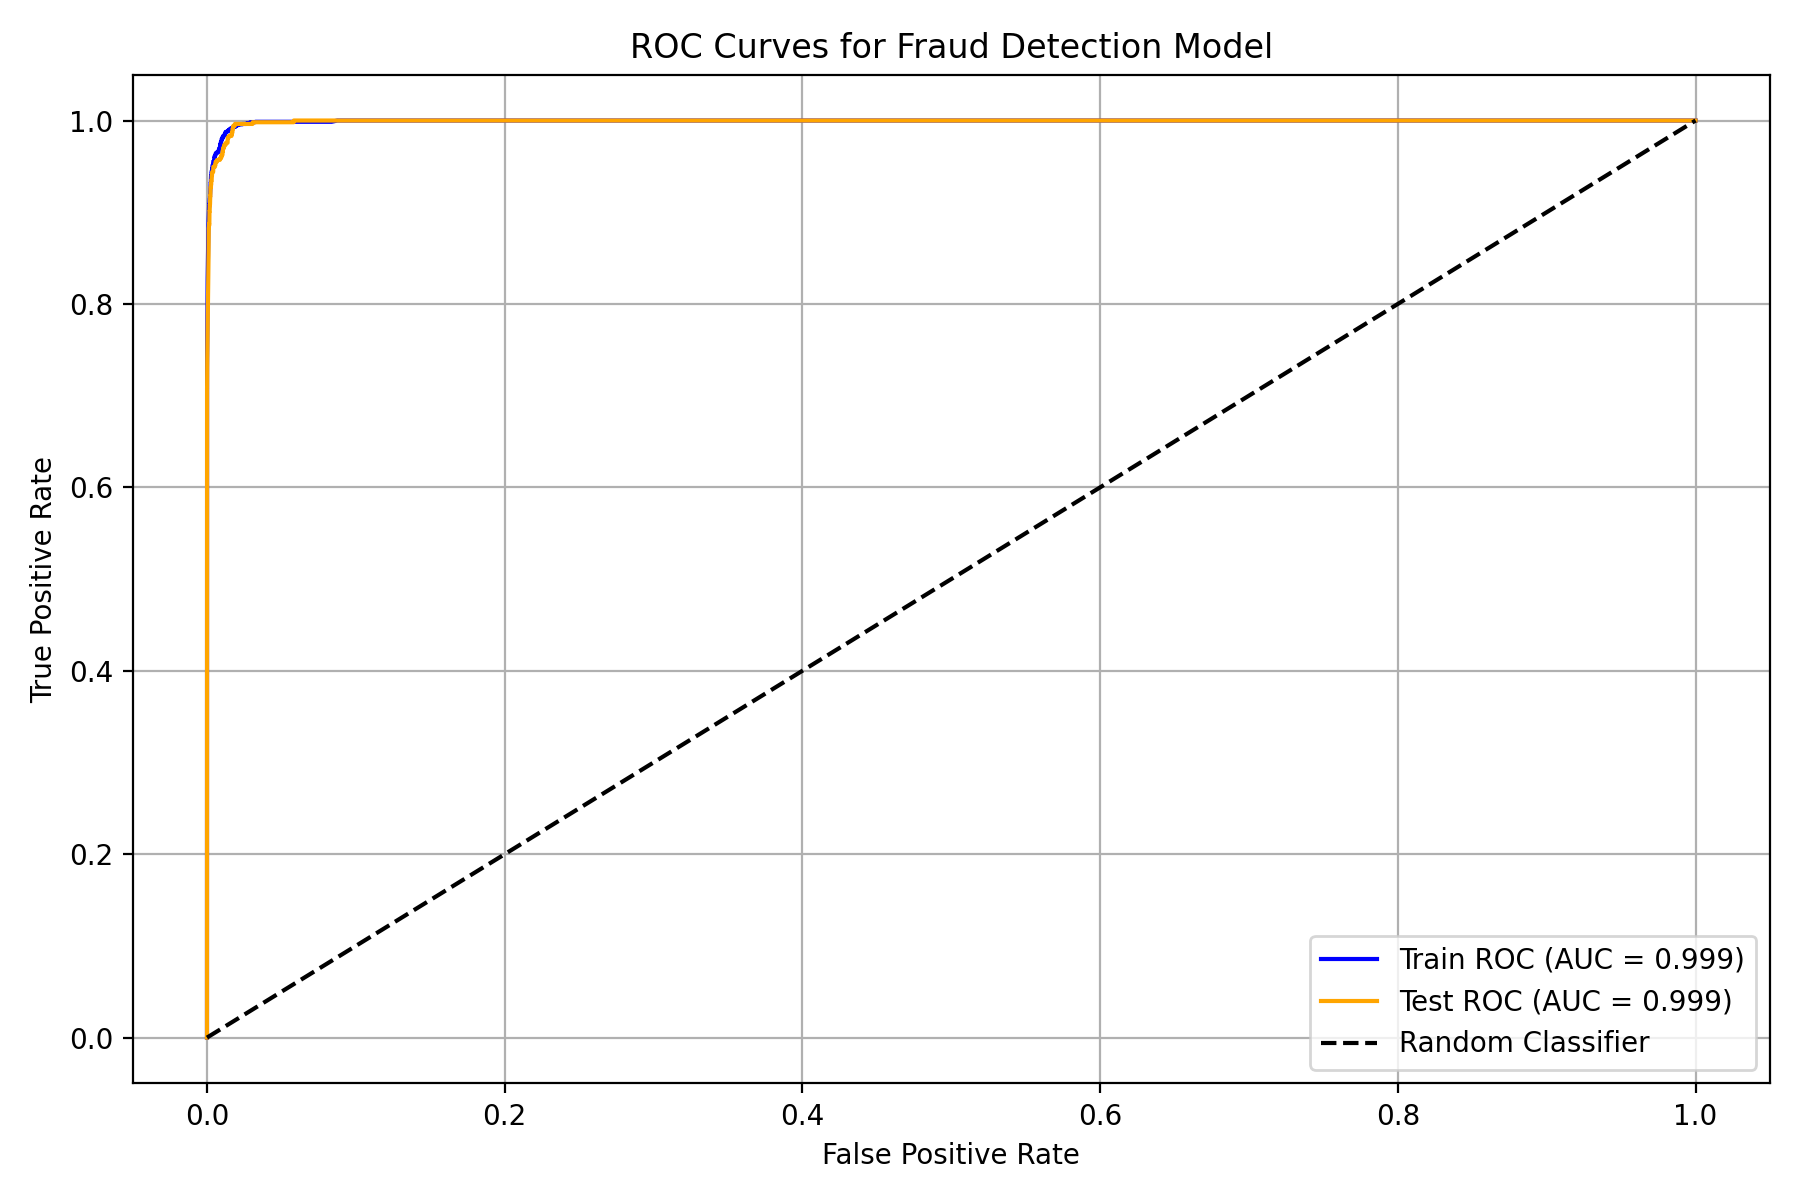

In [123]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_scores_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_scores_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(9, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.3f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Fraud Detection Model')
plt.legend()
plt.grid(True)
plt.show()
plt.tight_layout();

<IPython.core.display.Javascript object>


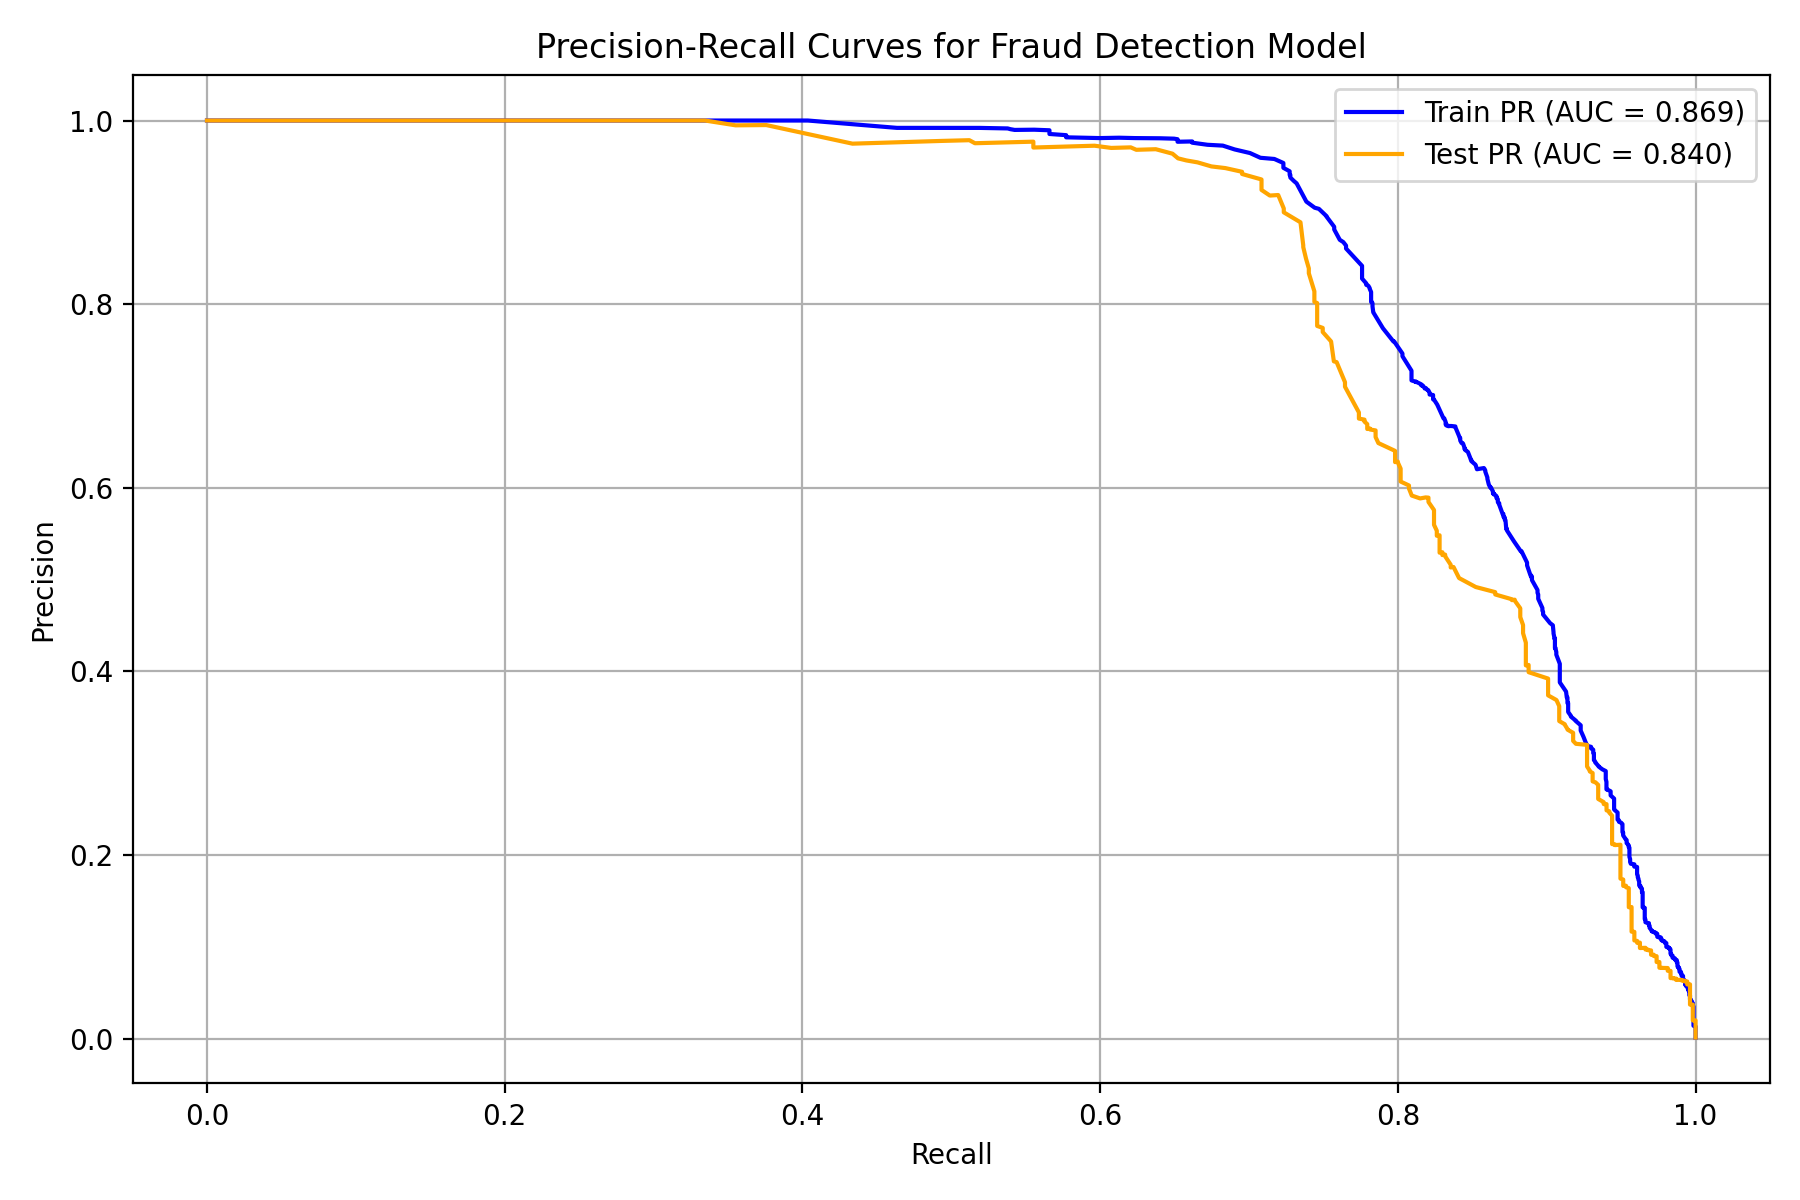

In [126]:
precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
pr_auc_train = auc(recall_train, precision_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)
pr_auc_test = auc(recall_test, precision_test)

plt.figure(figsize=(9, 6))
plt.plot(recall_train, precision_train, label=f'Train PR (AUC = {pr_auc_train:.3f})', color='blue')
plt.plot(recall_test, precision_test, label=f'Test PR (AUC = {pr_auc_test:.3f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Fraud Detection Model')
plt.legend()
plt.grid(True)
plt.show()
plt.tight_layout()

## SHAP

<IPython.core.display.Javascript object>


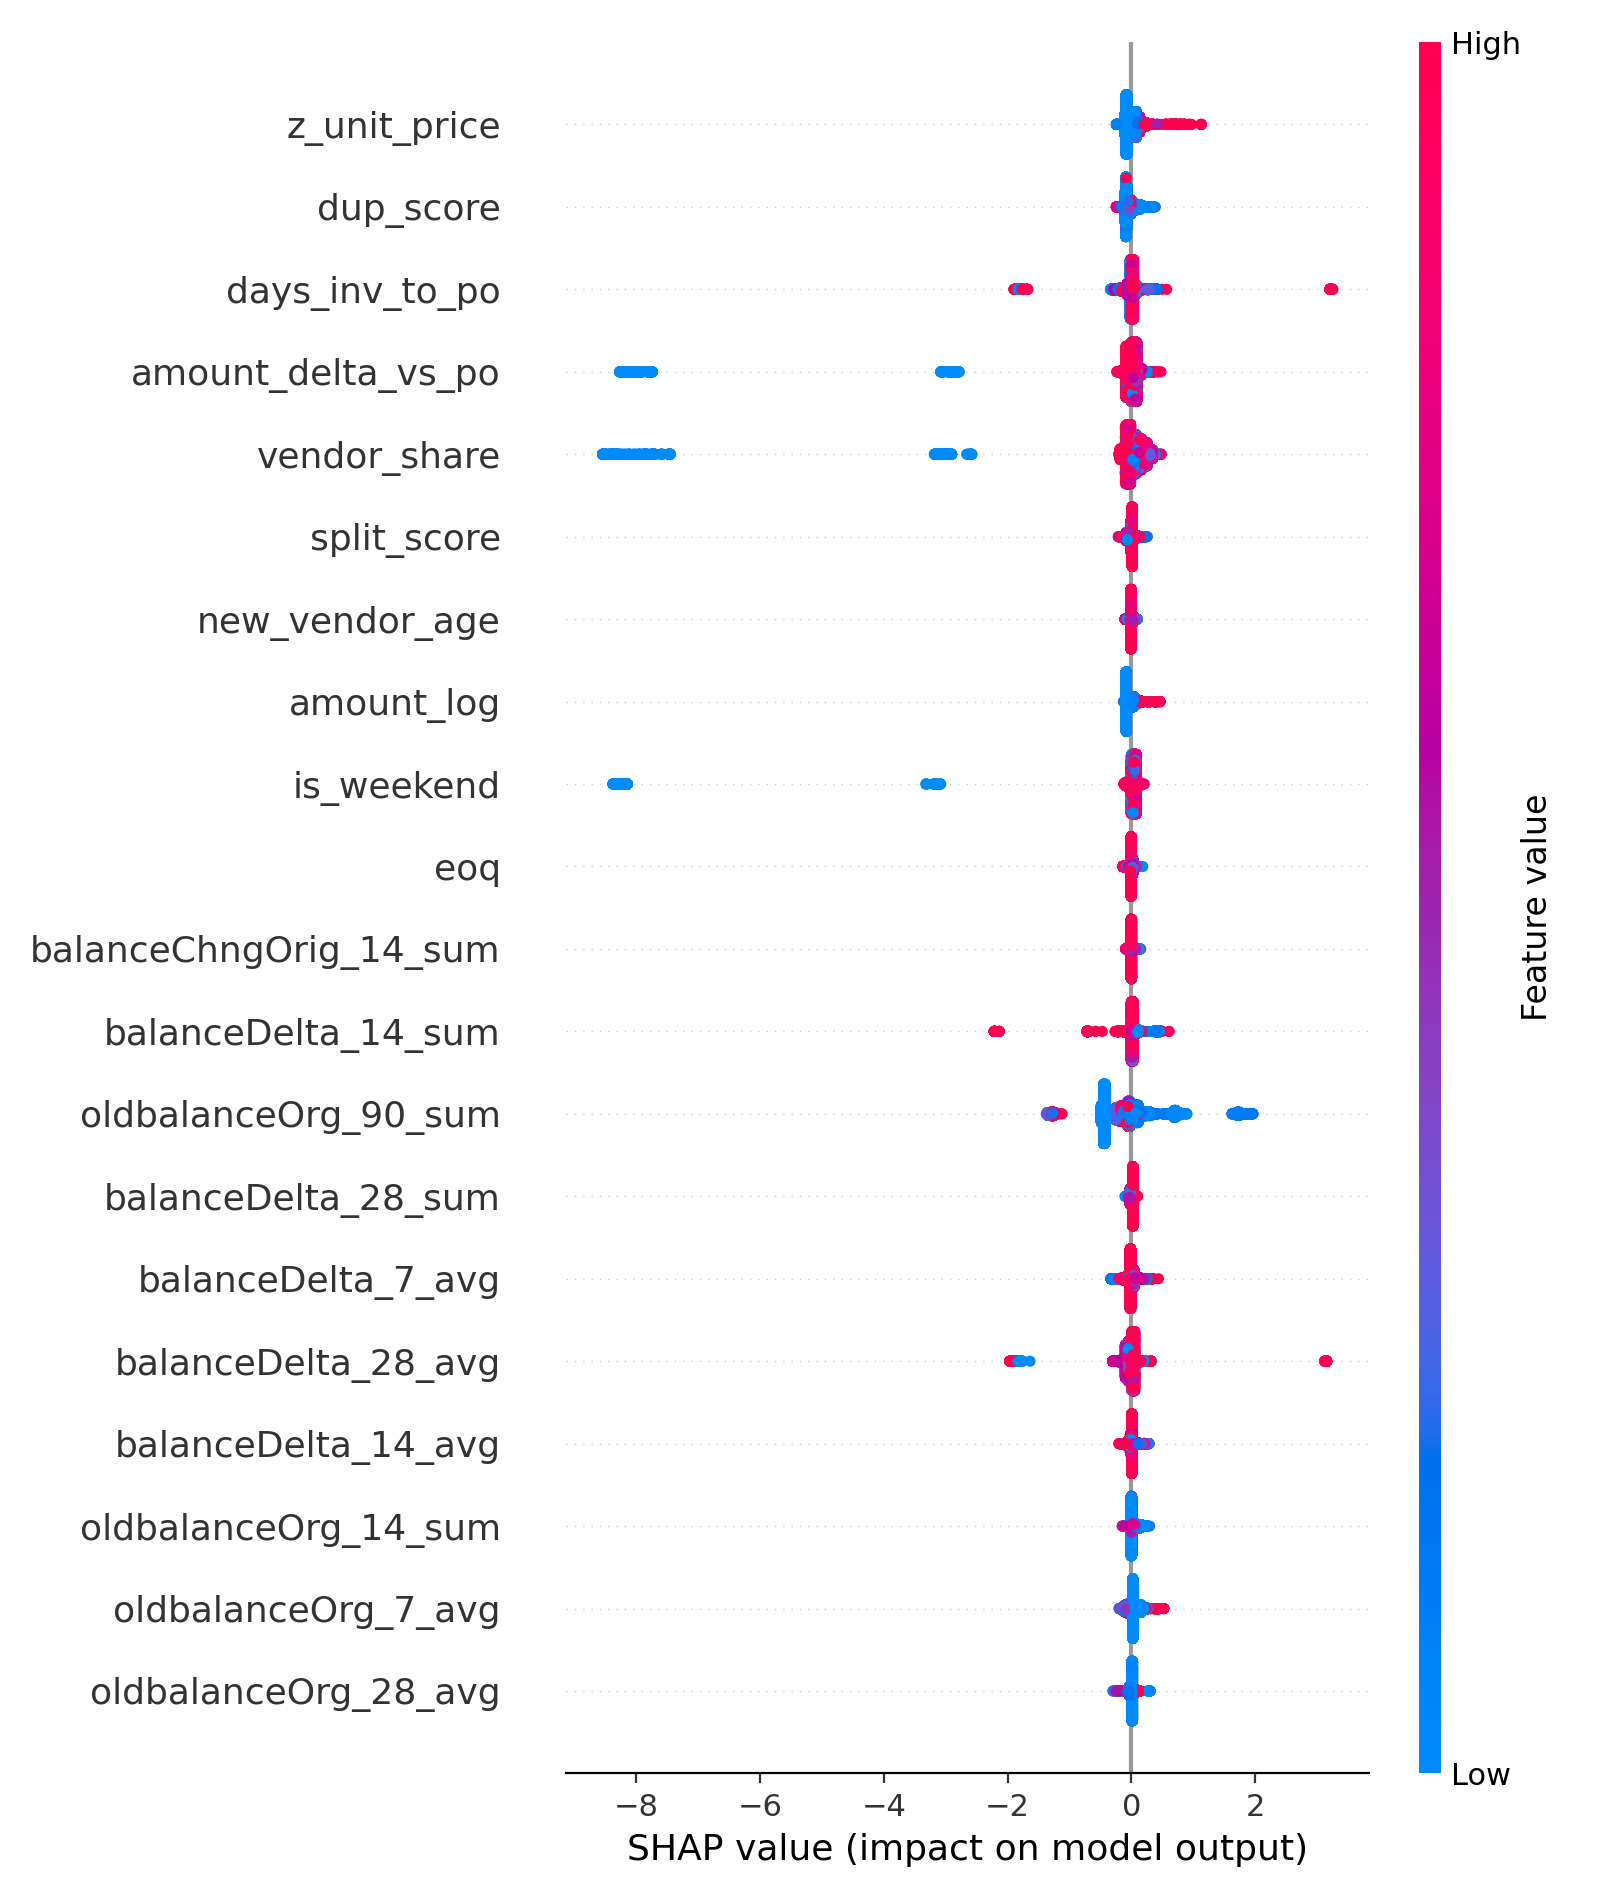

In [73]:
fig, ax = plt.subplots(1, 1)
X_s = df[important_features].sample(100000)
shap_values = shap.TreeExplainer(model.booster_).shap_values(X_s)
shap.summary_plot(shap_values, X_s, sort=False)


# Анализ когорт

In [151]:
valid_ys = pd.DataFrame({
    'y_test': y_test.values,
    'y_scores': y_scores_test
})

In [152]:
valid_ys = valid_ys.sort_values(by='y_scores', ascending=False)
valid_ys = valid_ys.reset_index(drop=True)


## Top 1%

<IPython.core.display.Javascript object>


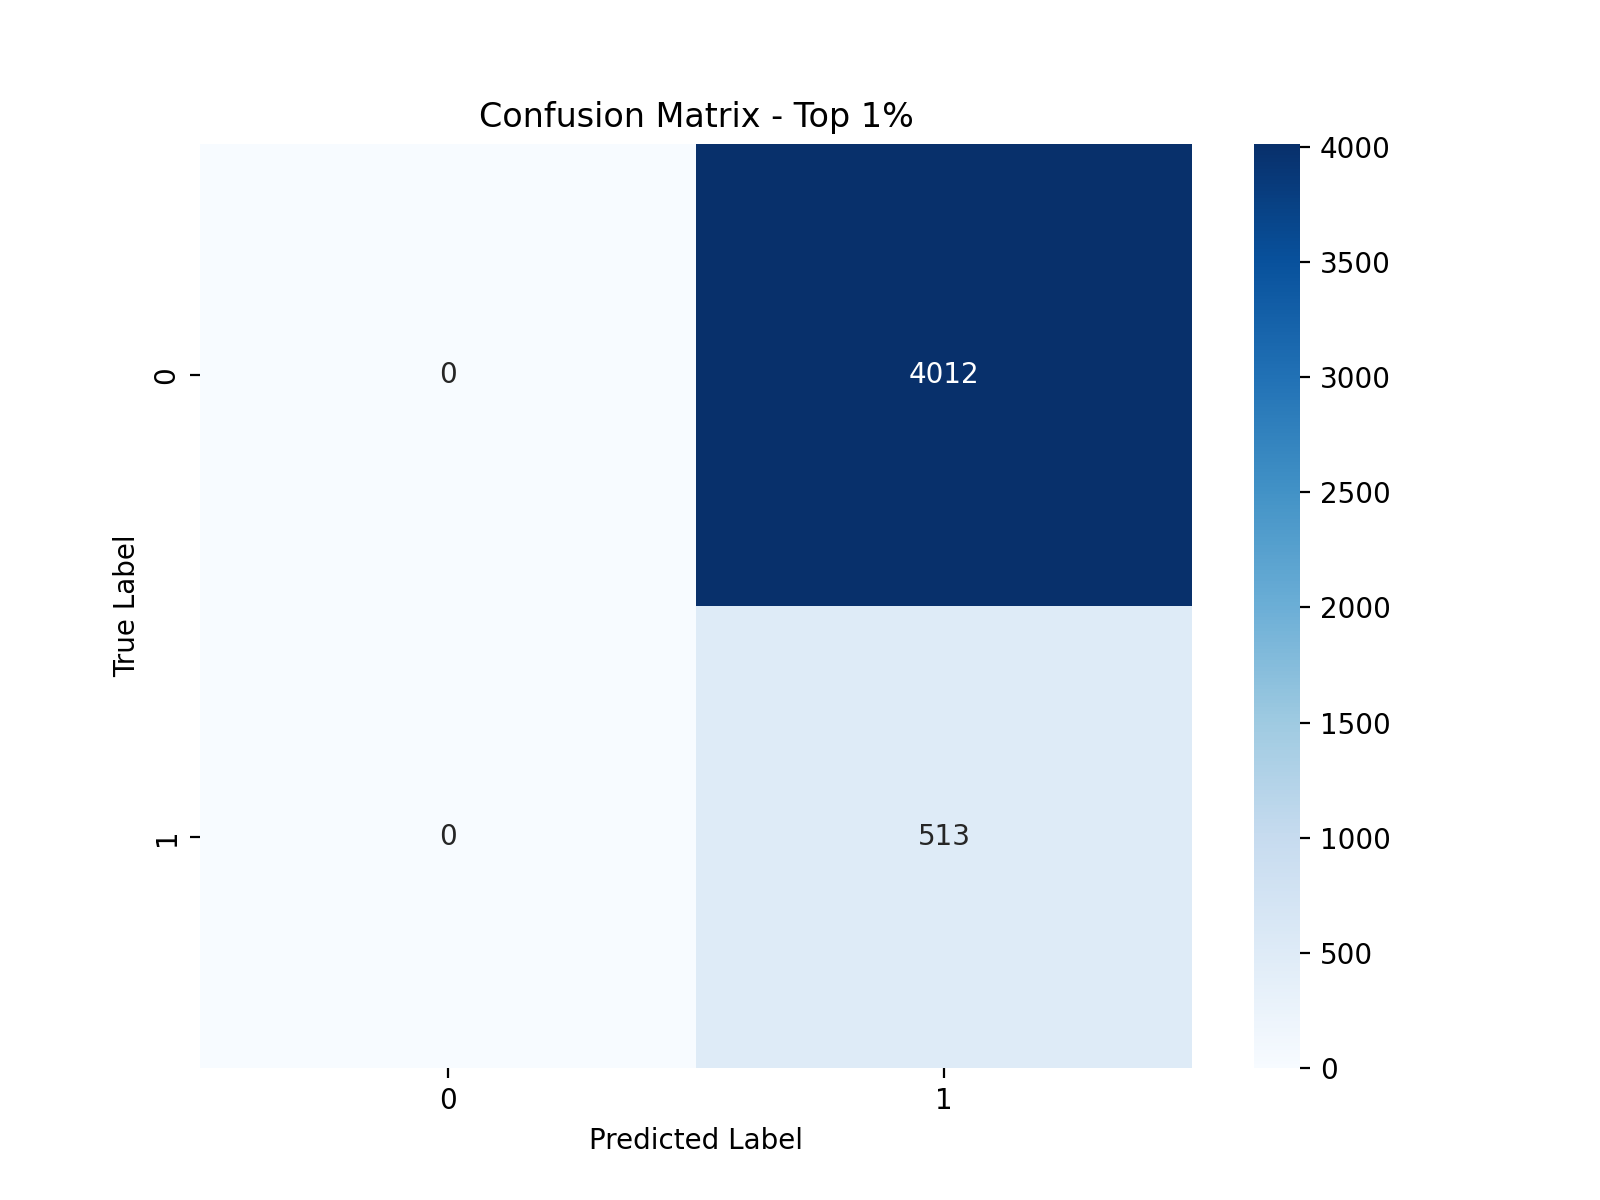

In [193]:
i = int(len(valid_ys) * 0.01)
v_slice = valid_ys.iloc[:i]

cm = confusion_matrix(v_slice.iloc[:, 0], np.ones(len(v_slice)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Top 1%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');


## Top 0.1%

<IPython.core.display.Javascript object>


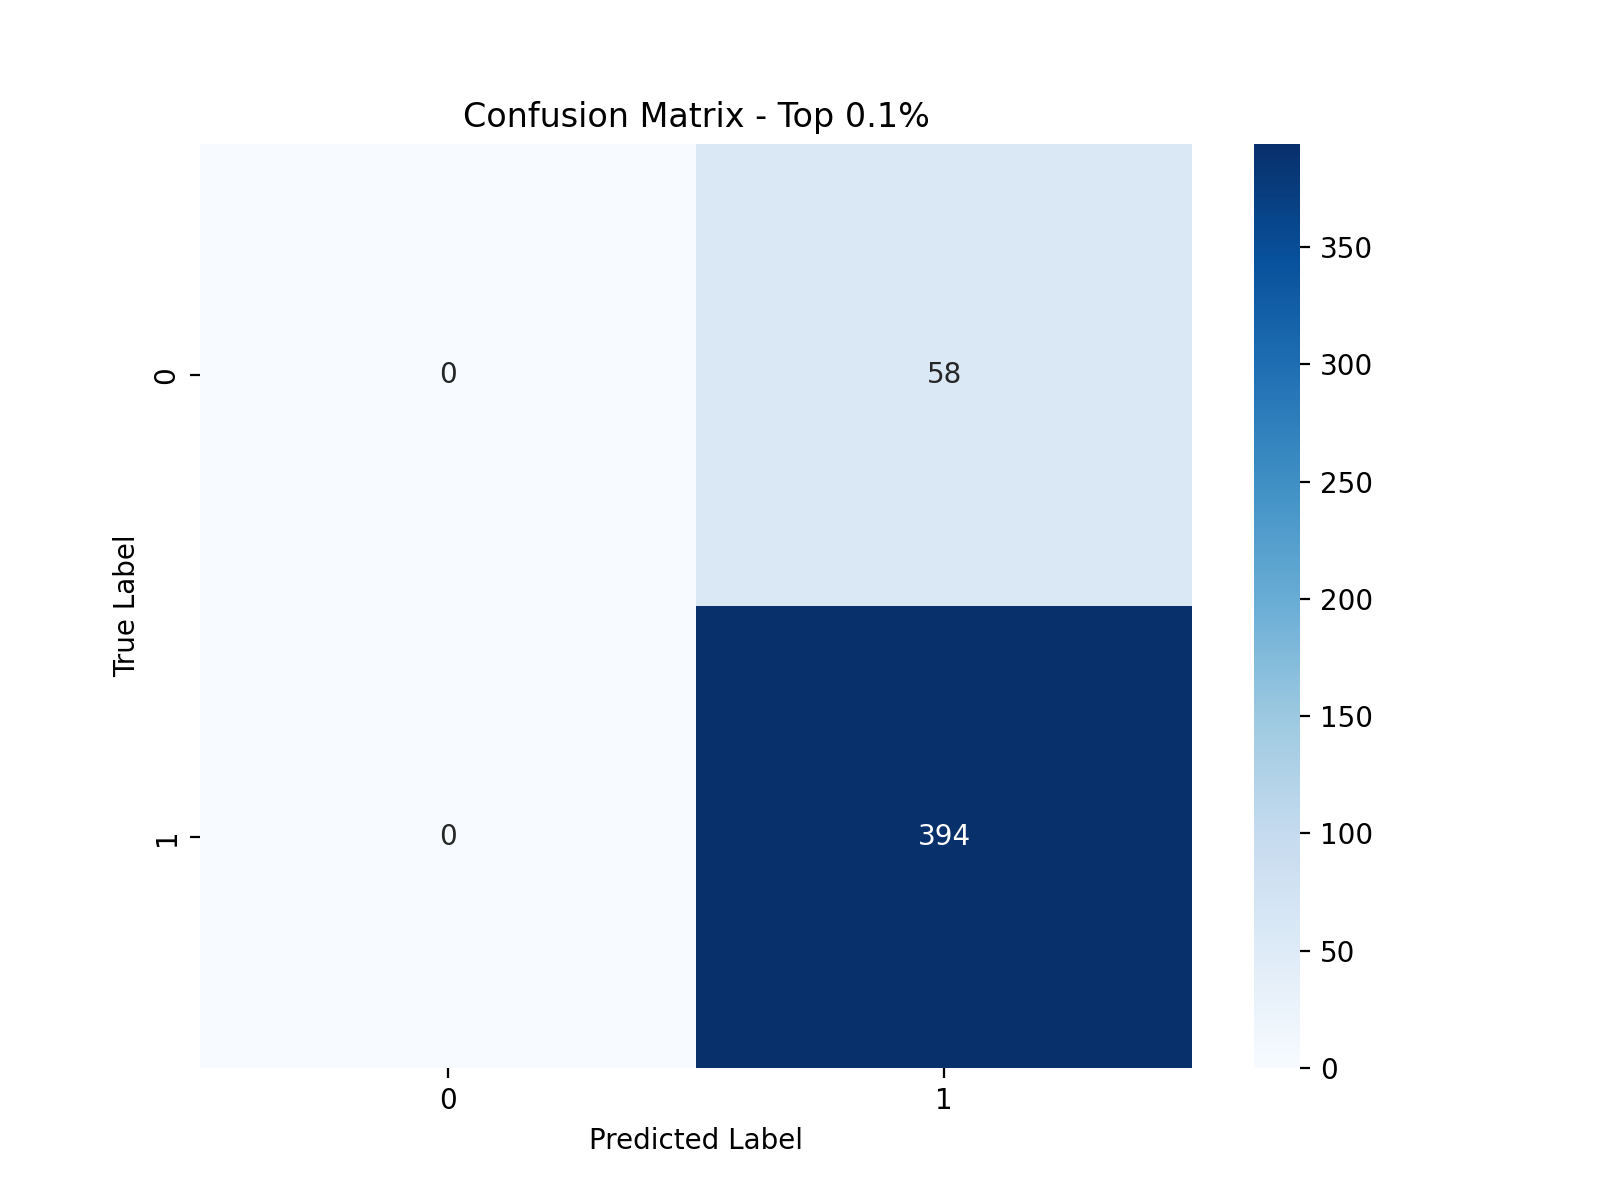

In [195]:
i = int(len(valid_ys) * 0.001)
v_slice = valid_ys.iloc[:i]

cm = confusion_matrix(v_slice.iloc[:, 0], np.ones(len(v_slice)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Top 0.1%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');


## Top 0.15%

<IPython.core.display.Javascript object>


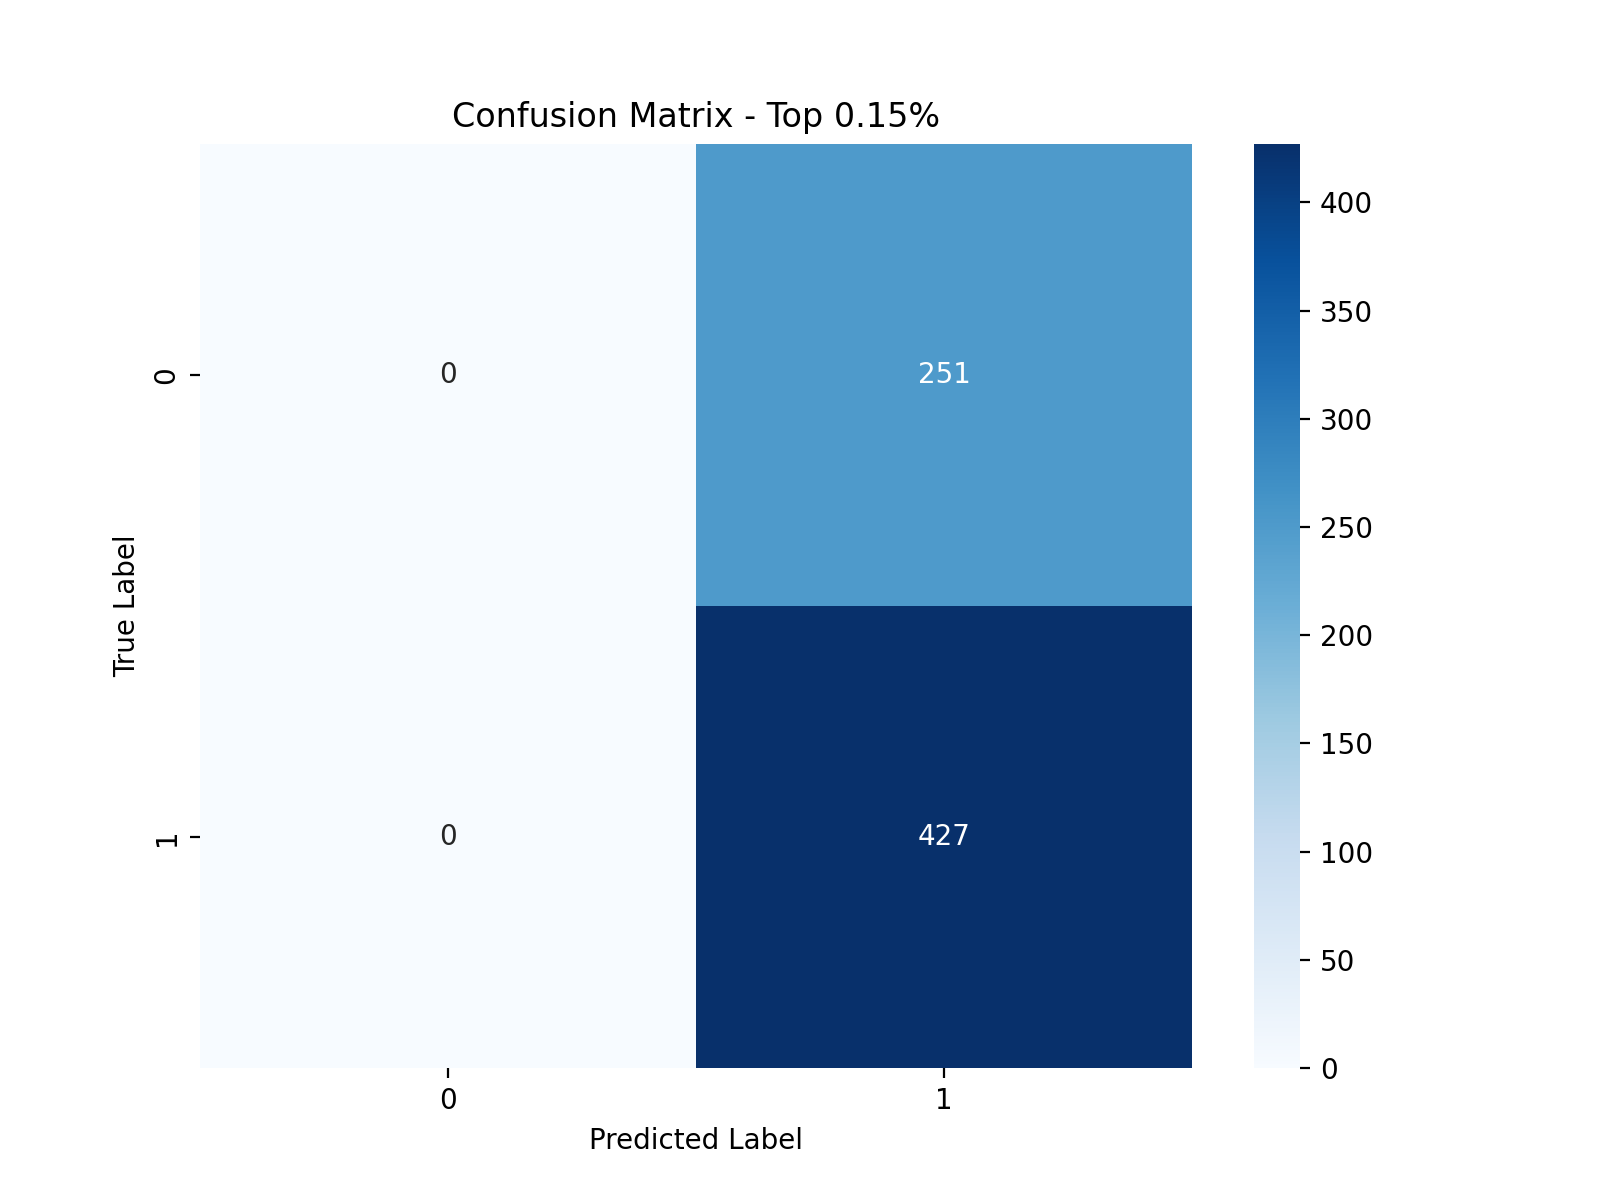

In [198]:
i = int(len(valid_ys) * 0.0015)
v_slice = valid_ys.iloc[:i]

cm = confusion_matrix(v_slice.iloc[:, 0], np.ones(len(v_slice)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Top 0.15%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');


## Top 0.05%

<IPython.core.display.Javascript object>


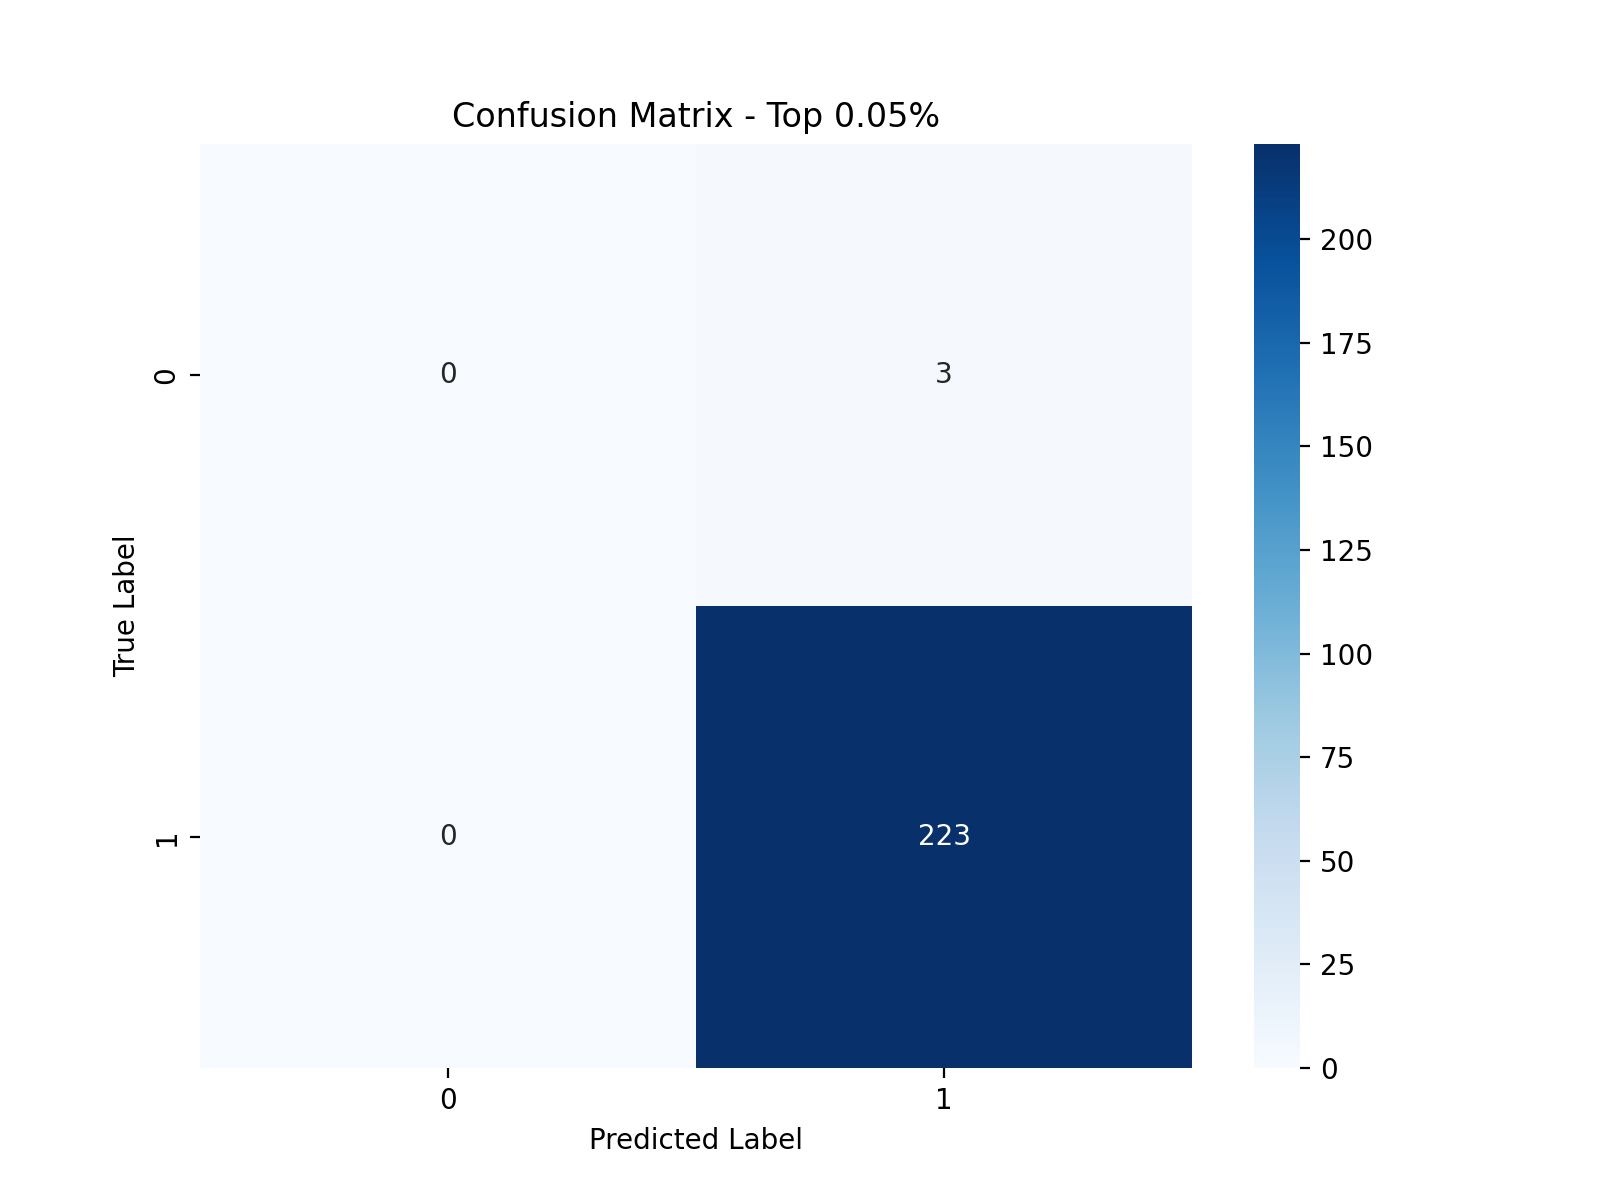

In [197]:
i = int(len(valid_ys) * 0.0005)
v_slice = valid_ys.iloc[:i]

cm = confusion_matrix(v_slice.iloc[:, 0], np.ones(len(v_slice)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Top 0.05%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');


- Различные пороги были протестированы на точность в когортах.
- Порог должен быть в пределах от 0.05% до 0.1% для максимальной точности.
- Охват при таком пороге в пределах от 40% до 80%, так как в общем в нашем валидационном сете 535 реальных фрод кейсов

# Сохранение модели

In [210]:
save_for_prod = {
    'model': model,
    'features': important_features,
    'shap_values': shap_values
}
joblib.dump(save_for_prod, 'prod_data.joblib')


['prod_data.joblib']